# 初めてのBluetooth LE: Arduino nano 33 BLE and python bleak library

Arduino nano 33 BLE/BLE sensorは Arduino が設計／生産／販売しているArduino 基板シリーズの一つです。
Arduinoの小型の基板ファミリ(nano)の一つで、Arduinoシリーズと共通なデジタル入出力端子とアナログ入力端子を備えています。また、PCと接続するためのUSB端子の他に、 Bluetooth Low Energy(BLE)による通信機能を備えているのが大きな特徴です。Arduino nano 33 BLEには、12-bit 200 ksps のADC機能や、慣性測定ユニット(IMU, Inertial Measuremnt Unit) LSM9DS1 ICが標準で搭載されています。LSM9DS1からは3軸の加速度、角速度、地磁気のデータを読み出せます。

Arduino nano 33 BLEのBLE機能を使うことで、まざまなセンサー素子を分散配置して、
広範囲(規格上は~100m)に広がったセンサからの情報を簡単に収集するシステムを構築できるなど大きな可能性をもっています。

Arduino nano 33 BLE/BLE Sensor 基板は、BLEの周辺装置としての利用に限定されることなく、
基板上で動作するArduinoプログラムを組み替えることで この基板をBLE ホストとし、その他のBLE周辺装置を制御することも可能です。

この基板に周辺装置として動作するプログラムを搭載し、PC(著者が利用したのはmacbook pro 13-inch M1 2020)からこの基板の制御を行ってみましたので、その内容をここにまとめておきます。

このメモは次のような内容を含んでいます。

1. Arduino Nano 33 BLE 基板の開発環境の準備
1. Arduino Nono 33 BLE 基板をBLE 周辺装置として動作させるプログラムの説明
    1) BLEデバイスとして認識させる。(アドバタイズメント)
    1) サービスとキャラクタリスティック(特性)を追加する。(リード プロパティ）
    1) BLEデバイスにデータを送信する。(ライト　プロパティ）
    1) デバイスから送信される通知データを受け取る（通知プロパティ）
1. LightBlueを使ったBLEデバイスの動作の確認
1. Python プログラムを使った動作の確認
1. Python によるアプリケーションの試作


## Arduino nano 33 BLEとMbed OS
(この節は、プログラム開発には直接には関係しません。読み飛ばしていただいても大丈夫です。）

### Arduino nano 33 BLEのCPU
Arduinoファミリーの基板には、Atmel社(2016年以降は、同社を買収したマイクロチップ・テクノロジー社が制作／販売）の AVRマイクロプロセッサーが長らく使われてきました。
ところが、Arduino nano 33 BLE/BLE sensor はコアとなるプロセッサに、
the Nordic nRF52840 Cortex-M4 microcontrolleを採用しています [[注 MKR]]。
その名が示すように、このプロセッサはArm Cortex-M4アーキテクチャのCPUです　。
これらのCPUの違いにもかかわらず、プログラム開発には, AVRベースの Arduino基板と同じ開発環境 **Arduino IDE** を使います。

Arduino IDEを使ったプログラムの開発では、基板に搭載されている機能の違いにより適切なライブラリを導入する必要はありますが、

1. プログラムをArduinoプログラム言語を用いて開発し、
1. それをターゲットとなるArduino基板向けにコンパイルして、ダウンロードする

と言う手順は同じで、基板のCPUタイプを意識する必要はありません。

Arduino nano 33 BLEなどの基板を使う場合には、Aruduino IDEのボードマネージャやライブラリマネージャを使って、必要なライブラリが導入されていることを
確認しましょう(下図を参照, はじめの図では、MbedベースのボードやmegaAVRのボードがサポート済みであることが確認できます。次の図では、ArduinoBLEライブラリがインストール済みであることが確認できます。）

![スクリーンショット 2022-10-11 10.27.23.png](attachment:e375179d-7bbb-40b2-9b3a-2e9c6f1bd500.png　"ボードマネージャの画面　MbedベースのボードやmegaAVRのボードがサポート済みであることが確認できる。 " )

![image.png]( attachment:4a15f263-bc8d-4ec0-a33f-b054099777fe.png 
　"ライブラリマネージャの画面。ArduinoBLEライブラリがインストール済みであることが確認できます。" )
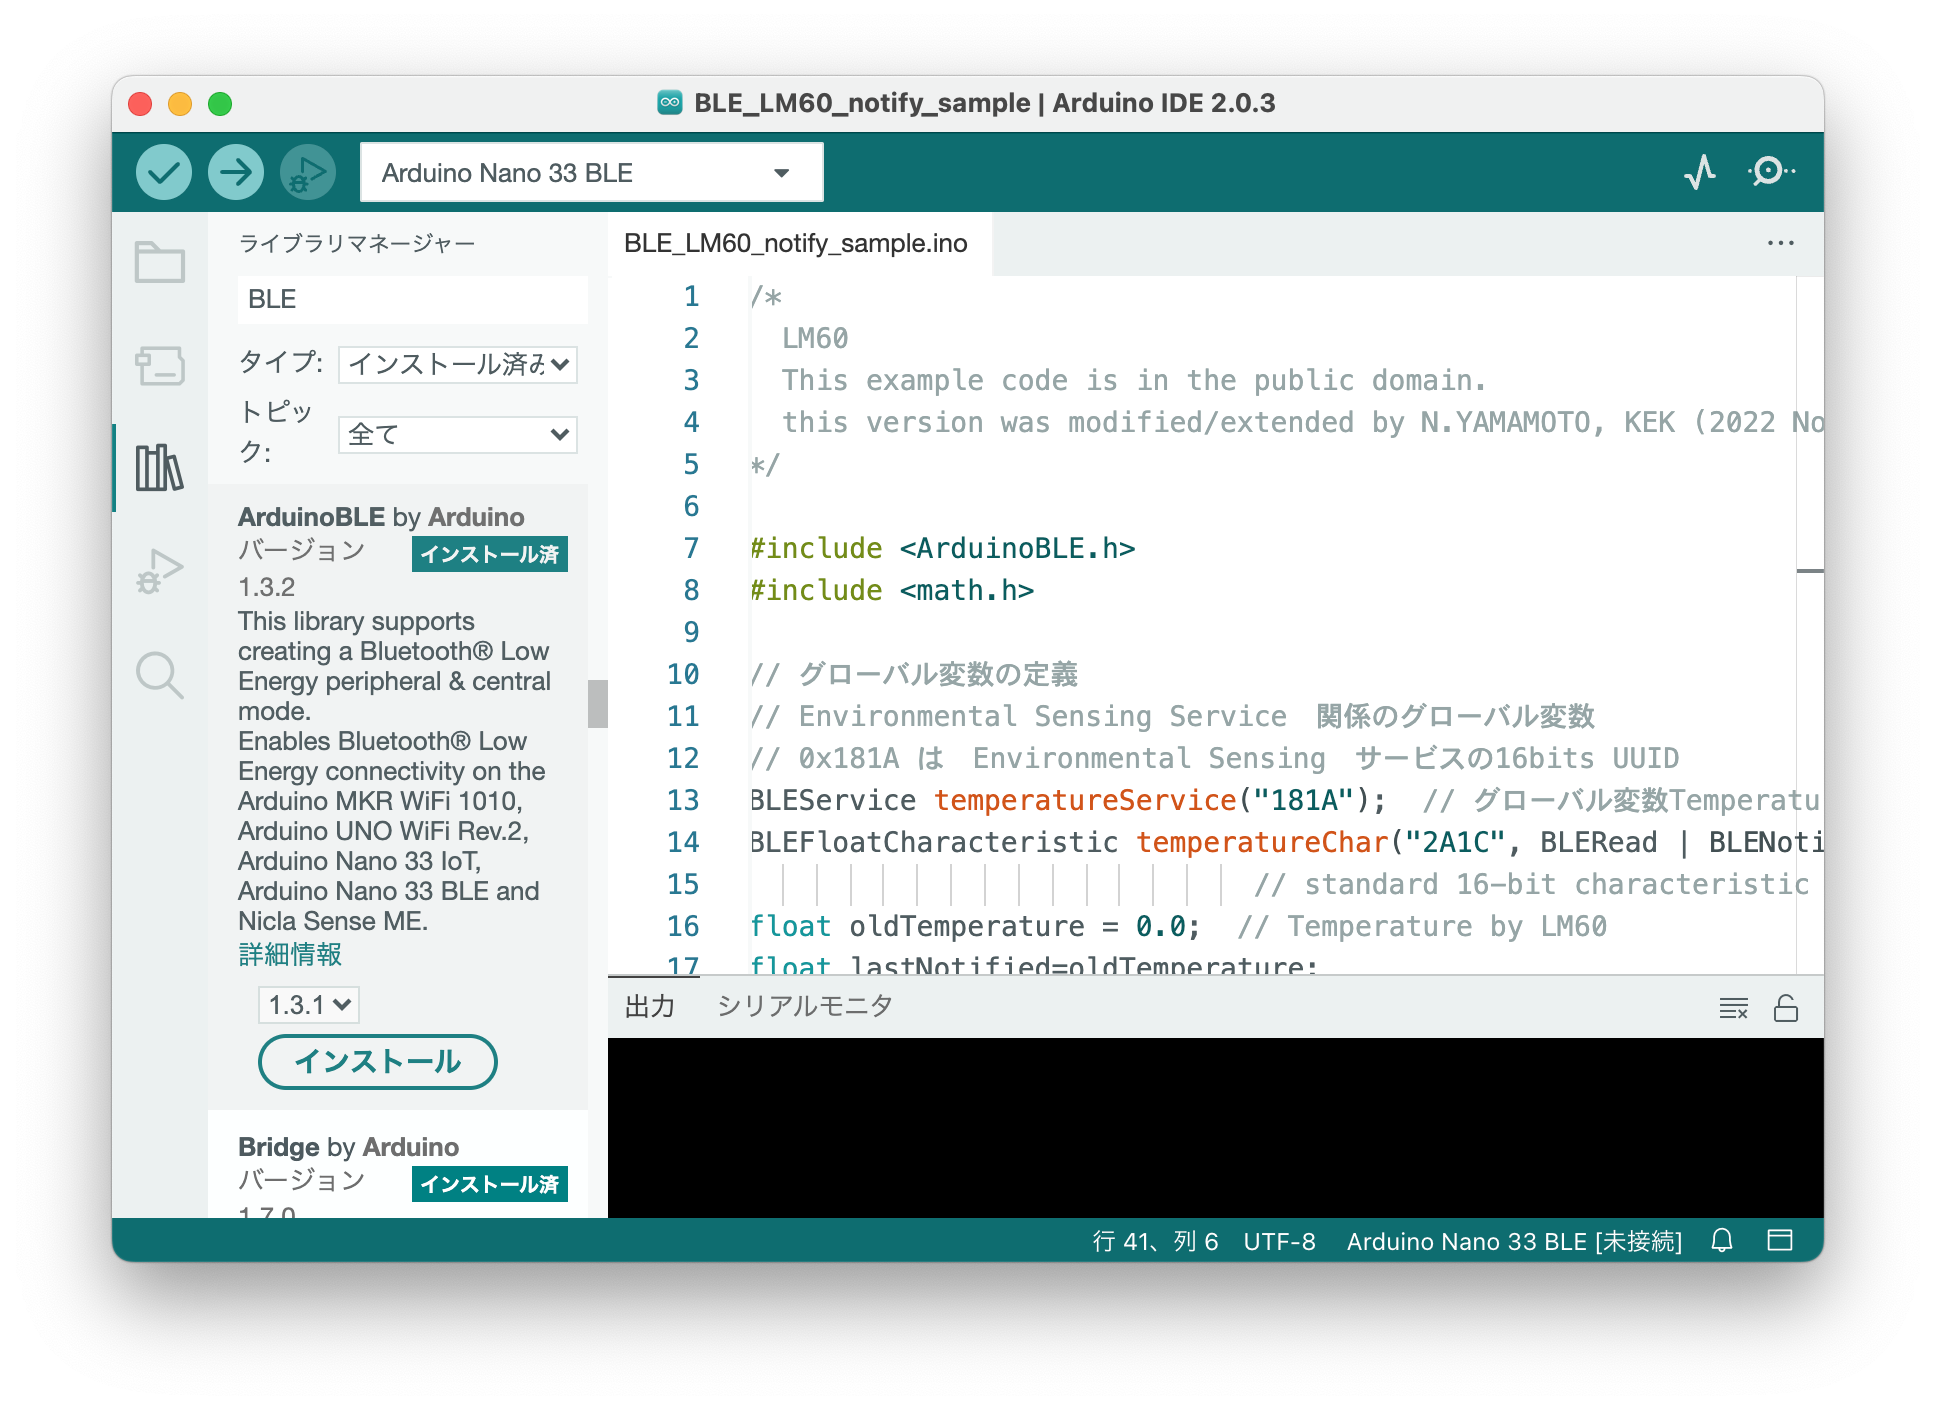
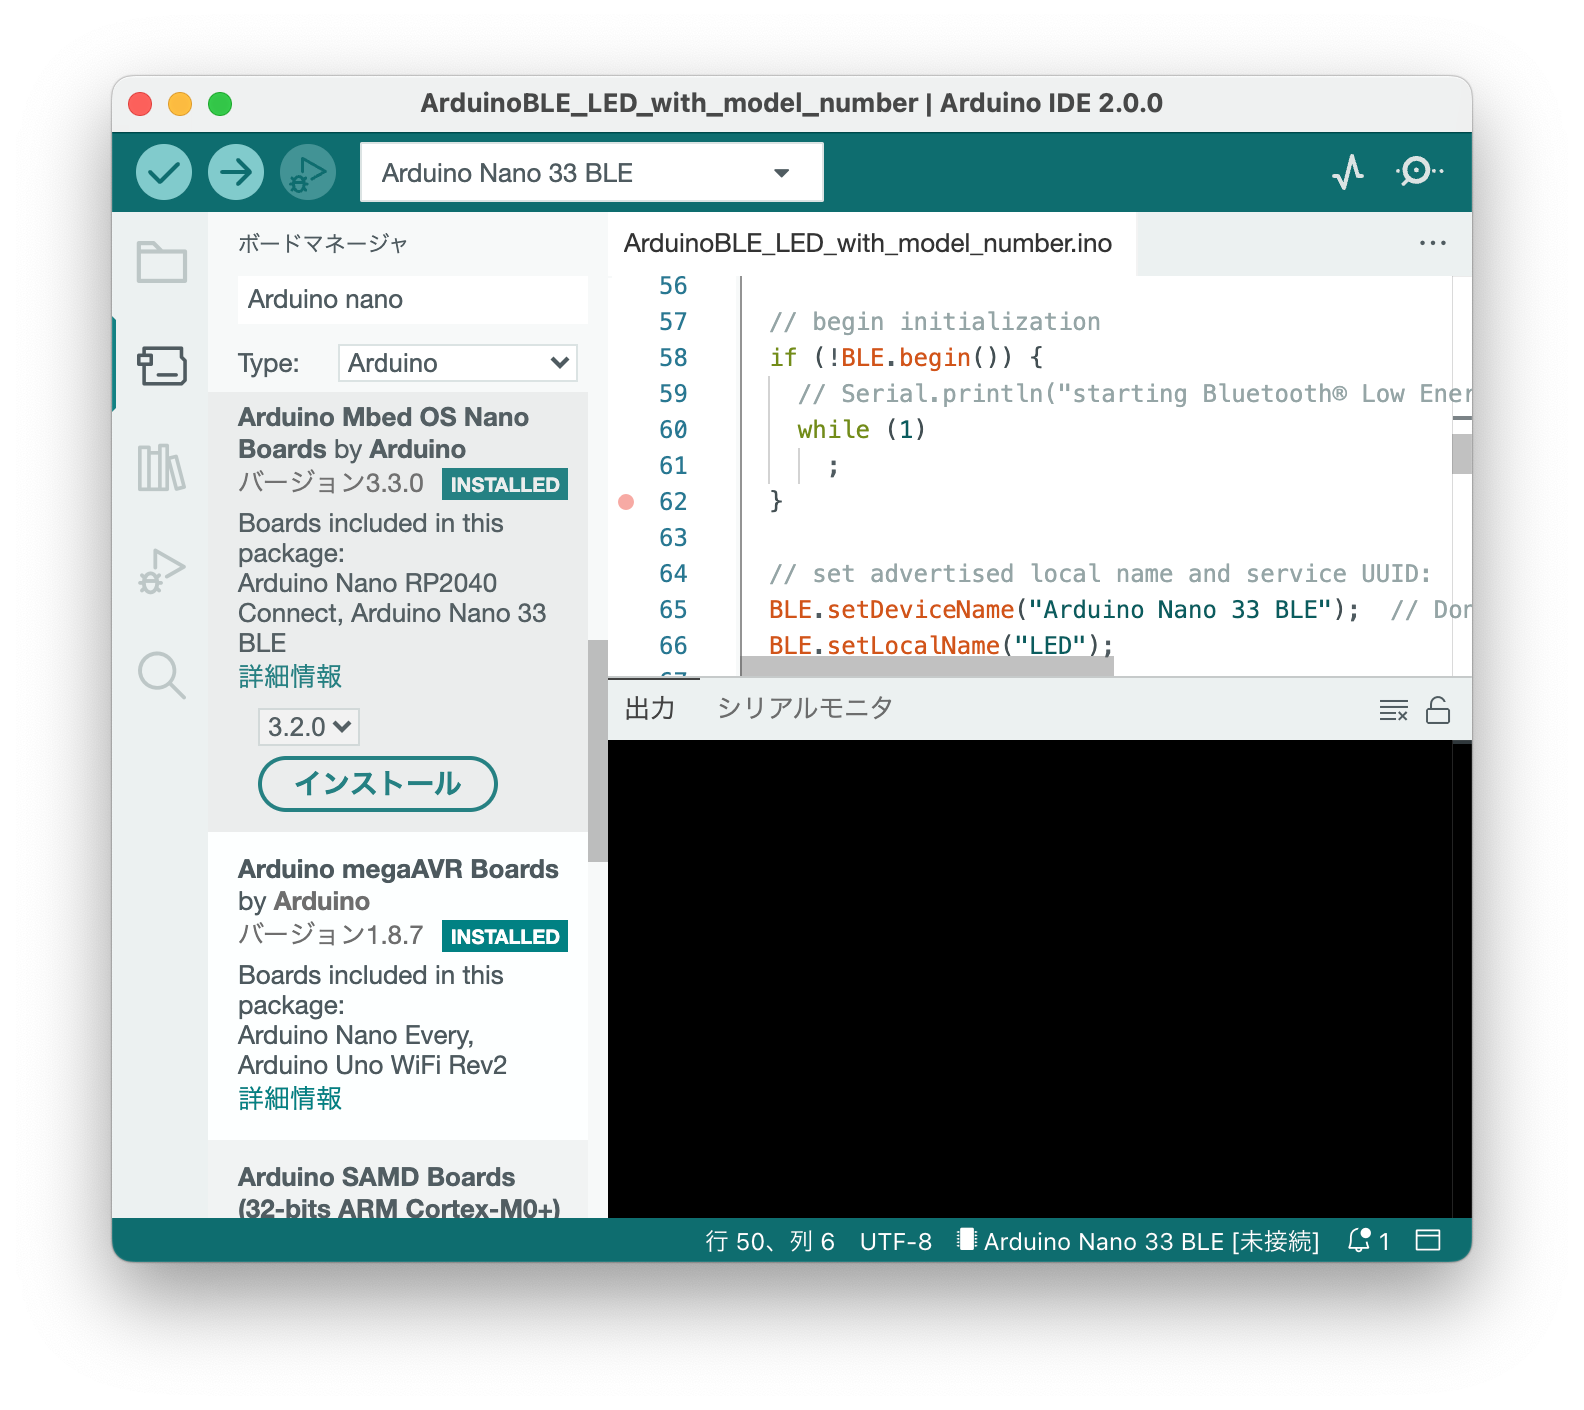

### MbedOSの採用

Auduinoは この新しいコントローラをサポートするにあたり、安定性／開発の継続性などを考慮して[`MbedOS`][MbedOS in Wikipedia]を[採用][Arduino nano MbedOS] し、この上にこれまで同様のArduino プログラムを利用するための環境を構築することを選んだようです 。
幸いなことに、Arduino IDE環境でArduino言語を使ったプログラムを使っている限り、このことを意識する必要はありません。

この環境では、`mbed::`名前空間を使うことで、ArduinoスクリプトからMbedOSの全ての機能を利用することもできるとのことです。
またこれによって、すべての`Mbed`ボードを、Aruduino環境に取り込むことが簡単になりました。
さらに、Mbedのプログラマは`arduino::`名前空間を使うことで、Arduinoの機能を利用することができます。

参考

- [Why we chose to build the Arduino Nano 33 BLE core on Mbed OS][Arduino nano MbedOS]


[注 MKR]: . "Arduino ファミリの　MKR シリーズでは Atmel社の ATSAMW25 SoCを採用しています。このマイクロコントローラーは ARM の Coretex-M0 アーキテクチャを採用しています。"

[注 AVR]:.  "AVR CPUの基板には、ダウンロードされたバイナリプログラムを実行するだけの機能を持った、モニタープログラムが実装されていました。"

[Arduino nano MbedOS]: https://blog.arduino.cc/2019/07/31/why-we-chose-to-build-the-arduino-nano-33-ble-core-on-mbed-os/?queryID=undefined

[MbedOS in Wikipedia]: https://ja.wikipedia.org/wiki/Mbed

# Aruduino IDE： Arduino　基板の開発環境

Arduino nano 33 BLE基板に、Arduinoスクリプトによるプログラムを書き込むことで、基板をBLEのデバイスとして利用できます。
このプログラムの書き込みには、**Arduino IDE** アプリケーションを使います。

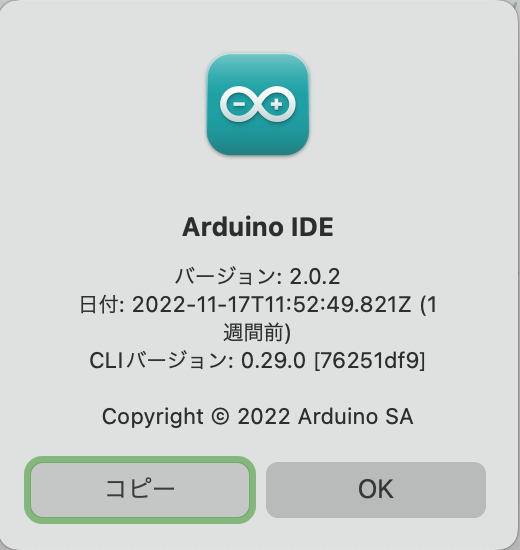

`Arduino IDE` は、当初 [Processing](https://processing.org/) をベースに開発されていましたが、現在は　[Electron](https://www.electronjs.org) をベースに開発されているようです。Arduino IDEでは、[Wiring](https://wiring.org.co/) のアイデアに基づき、機器操作のためのプログラムを独自のプログラム言語(Arduino 言語：C++に極めて類似している）を使って、プログラムを開発します。Arduinoの基板はCPUのタイプに関係なく同じArduino IDEを使って、Aruduino 言語を使ってのプログラム開発／ダウンロード/プログラムの実行までが行えます。


## Arduino IDEの入手

Arduino IDEはArduino社が提供する Arduino 基板用のプログラム開発環境です。Winodws, Linux, macosで動作します。

Arduino IDEは　[Arduino Software Download](https://www.arduino.cc/en/software) からダウンロードしてインストールします。
Arduino IDEのソースコードもオープンソースとして　[GitHub](https://github.com/arduino/arduino-ide)　で公開されています。[注1]

macos版、Windows版は それぞれのプラットフォームで動作するアプリケーションあるいはインストーラーが用意されています。　
それらを使ってArduino IDEアプリケーションをインストールします。

Linux向けには`AppImage`形式のバイナリが配布されています。
`AppImage`形式のバイナリは、次の手順で、アプリケーションとして動作させることができます
（[参考：LinuxでAppImage形式のアプリを使う方法と注意点のまとめ](https://virment.com/how-to-use-appimage-linux/)）。

  1. ダウンロード サイトからAppImageファイルをダウンロードして、適当な場所に保存します。
  1. ダウンロードしたイメージファイルに実行権限を付加します(`chmod +x`コマンドあるいはGUIを使って、実行権限を付加)。
  1. 実行権限をつけたファイルを起動します。


[注1]: . "`.cc` は、国別コードトップレベルドメイン (ccTLD) の1つで、オーストラリア領ココス諸島に割り当てられています。 当初は、1997年10月にIANAからアメリカ合衆国ワシントン州シアトルのeNICに割り当てられていましたが、現在このドメインはVeriSignが子会社eNICを通じて管理しています。「次なる.com」と宣伝し、国際的に売り出されています。"

### Arduino IDEの使い方

「Arduino IDEの使い方」については、既存の文献をご覧ください。
WWWを検索して、こう言うのが見つかりました。：

 * [Arduinoの開発環境の作り方とスケッチ例の使い方](https://smtengkapi.com/engineer-arduino-ide)
 
他にも雑誌, Webなどを探してみてください。

* [Accessing Accelerometer Data on Nano 33 BLE](https://docs.arduino.cc/tutorials/nano-33-ble/imu-accelerometer)
* [Controlling RGB LED through Bluetooth®](https://docs.arduino.cc/tutorials/nano-33-ble/bluetooth)

#### 開発したプログラムのダウンロードと実行
Arduino IDEを使って開発したプログラム(Arduino言語では`スケッチ`と呼ばれます）を
実行するには次の手順に従います。

1. IDEを起動したPCとArduino基板を適切なUSBケーブルで接続しましょう。 基盤の開発時期によって、Type-B, mini, micro などが使われています。
1. スケッチのウィンドウで、基板のタイプと接続されたUSBポートを設定しましょう。
1. （省略可能）スケッチをコンパイルしてエラーがないことを確認します。エラーがあれば、エラーが出なくなるまで、スケッチを書き直しましょう。
1. IDEのダウンロードボタンを押して、完成したプログラムを基板にダウンロードします。前項でコンパイルを行なっていても、ここでもコンパイルが行われます。コンパイル／ダウンロードの進捗状況のメッセージが表示されるので、ダウンロードが完全に完了するのを、**静かに待ちましょう**。

プログラムのダウンロードが完了すると、基板上のスケッチの実行が始まります。
スケッチ上で`Serial`デバイスに出力を行なうことで、IDEのシリアルモニタ上でスケッチの動作を確認できます。

こうしてスケッチをダウンロードしたArduino 基板は、PCと接続されていなくても、電源を供給するだけで、このスケッチの実行を始めます。

##### Aruduino 基板を単独使用する場合の注意

ここで注意が一つ。`Serial`にメッセージを出力するスケッチでは、基板のシリアルポートに端末が接続されていないと、シリアル装置からの応答待ちのところで、スケッチが停止してしまいます。このような事態を避けるために,　スケッチ内でメッセージを出力する際は：

``` c++
  if (Serial) {
      Serial.print("Hello ");    // 文字列を出力
      Serial.println("World!");　// 改行付きで出力
  }
```

などとすることで、メッセージの出力はシリアル端末(USB接続されたPCを含む)に接続されている場合に行いましょう。

## ArduinoBLE ライブラリ

Arduino nano 33 BLE基板をArduinoプログラム開発環境を使ってプログラムする際には、[ArduinoBLE ライブラリ][ArduinoBLE]が必要です。このライブラリによって、Bluthooth LE をこのボードで利用できるようになります。
このライブラリは、 Arduino IDE の Library Managerから簡単にインストールできます。

[ArduinoBLE]: https://www.arduino.cc/reference/en/libraries/arduinoble/


![スクリーンショット 2022-10-11 10.26.43.png](attachment:5f9c5ae5-5978-4010-9901-a94beadfa250.png "ライブラリマネージャ画面：ArduinoBLEのバージョン1.3.2がインストール済みであることが確認できます。")
この図では、ArduinoBLEライブラリのバージョン1.3.2がインストール済み(*installed*)である事が確認できます。まだインストールされていない場合は、最新のバージョンを選択して インストール　しましょう。

このライブラリをインストールすると、Arduino IDE から ArduinoBLE の Example のスクリプトが選択できるようになります。スケッチ例には**Central**と**Peripheral**の2種類があります。**Central**では、Arduino nano 33 BLEからBLEのデバイスにアクセスする例が収められています。**Peripheral**には、Arduino nano 33 BLEをBLEのデバイスとして、PCからアクセスできるようにする例が収められています。このメモでは**Peripheral**のスケッチを参考にしています。

![image.png](attachment:3e59428f-840c-4181-989b-3299b5c16b65.png "ArudinoBLEサンプルには、CentralとPeripheralの2種類のスケッチがあり、それぞれ複数のスケッチ例が用意されています。")


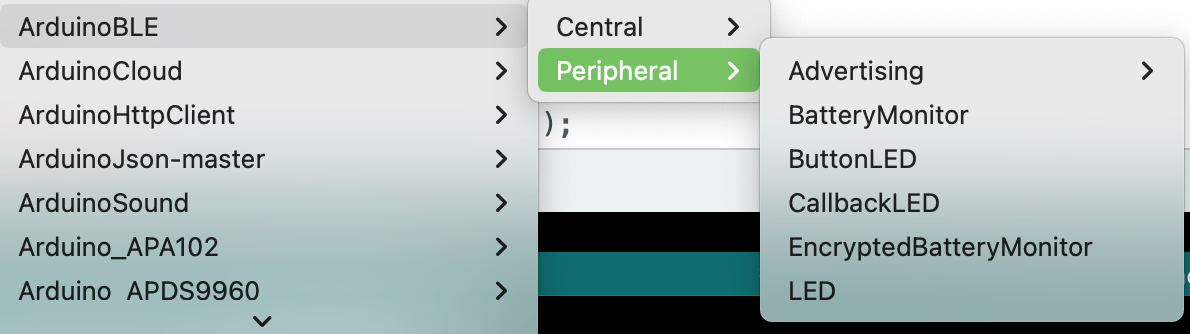
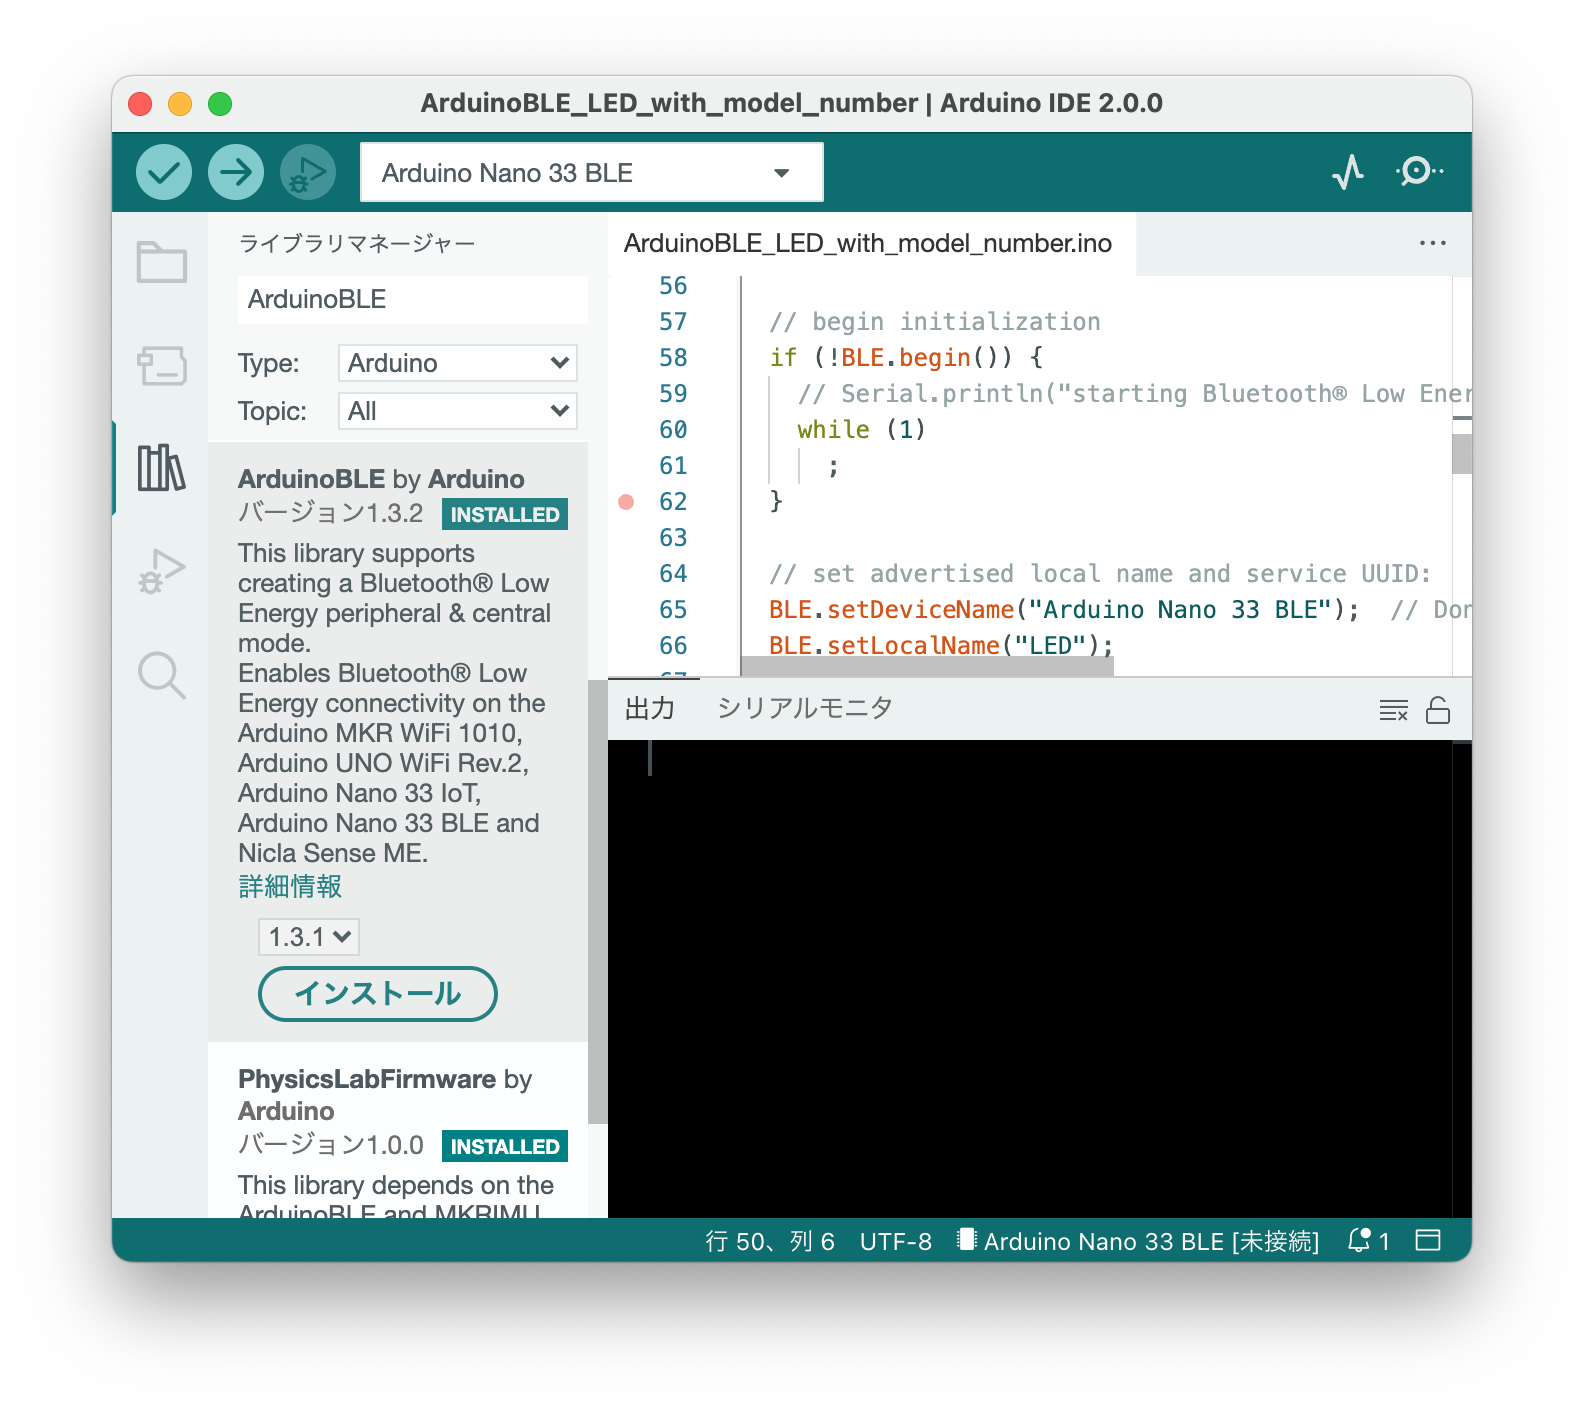

## Bluetooth LE(Low Energy)について
[ArduinoBLE Library]: https://www.arduino.cc/reference/en/libraries/arduinoble/

Bluetooth LE(Low Energy)とpython bleak library については、[このシリーズ](https://j-parc.jp/ctrl/documents/Articles/index.html) の
[「iPadとPythonを使って学ぶ, 初めてのBluetooth LE」](https://j-parc.jp/ctrl/documents/Articles/index.html)などをご覧ください。

参考
:[「BLE - 概要」を解説したページ](https://shizuk.sakura.ne.jp/bluetooth/ble/overview.html　"「BLE - 概要」の解説" )

### BLEを利用するためのライブラリ

Pythonでは `bleak` モジュールを使うことができます。　お使いのPythonでbleakモジュールがまだ使えない場合には、
`python3 -m pip install bleak" としてbleakモジュールをインストールしておきます。

#### python以外のBLEライブラリ

実験的にBLEをwebページ中で使うために、Web API（実験的）が定義されています。
正式に採用されると、その利用は大きく広がる可能性があります。

https://developer.mozilla.org/en-US/docs/Web/API/Web_Bluetooth_API

関係ありませんが、Web SpeechのAPIはこちらです。Web APIとJavascriptの利用が広がっています。 BLE もjavascriptから自由に使えるようになると、応用の可能性が広がります。

:  https://developer.mozilla.org/en-US/docs/Web/API/Web_Speech_API


## BLE Mnimal

まず最初に、Arduino nano 33 BLE をBLE ペリフェラル(つまり、PCなどから操作できるBLEのデバイス）として使うための**最小**のArduinoスクリプトを見てみましょう。このスクリプトをArduino nano 33 BLEにダウンロードして起動すると、Arduino nano 33 BLE はBLEのデバイスとしてPCからBLE デバイス探索で検知できるようになります。

In [1]:
#Aruduino スクリプトのコンパイルとダウンロード
from IPython.display import Video
Video('./_movies/画面収録 2023-01-24 19.05.00.mov',height=250)

### 動作を確認してみましょう。

Arduino nano 33 BLEが、実際にBLEデバイスとして動作していることを、確認してみましょう。

まずは、Linux/Androiod/iOS/macOSなどで利用可能なツール[LightBlue](https://punchthrough.com/lightblue/ "LightBlue by PuchThrough")を使い、このデバイスを見てみます。
LightBlueはウェブサイトから無料でダウンロードできます。


LightBlueの起動画面には、周囲にあるBLEデバイスのリストが表示されます(次の図）。
この検索窓で`Aruduino nano 33 BLE`が　**Aruduino BLE** として表示されていることがわかります。

![image.png](attachment:2834cf37-0aa6-4b34-a699-f004c7af9064.png "LightBlue のデバイスリスト画面")

画面で、このデバイスを選択して開くと、デバイスに接続されます。
デバイスとの接続が完了すると接続されたデバイスの詳細なデータが表示されます。
このArduino nano 33 BLEのUUIDや、 advertisementデータなどが確認できます（次の図)。


![image.png](attachment:8fc50ae2-8c09-4d73-bc0d-9a2d85052300.png "デバイス接続後の機器情報画面")



Arduino IDEのシリアルモニタ画面でも接続を確認できます（次の図).

![image.png](attachment:cc9aa7d3-60e4-4b08-8e47-794e136026bf.png "IDEのシリアルモニタ画面に表示されたスケッチからの出力")
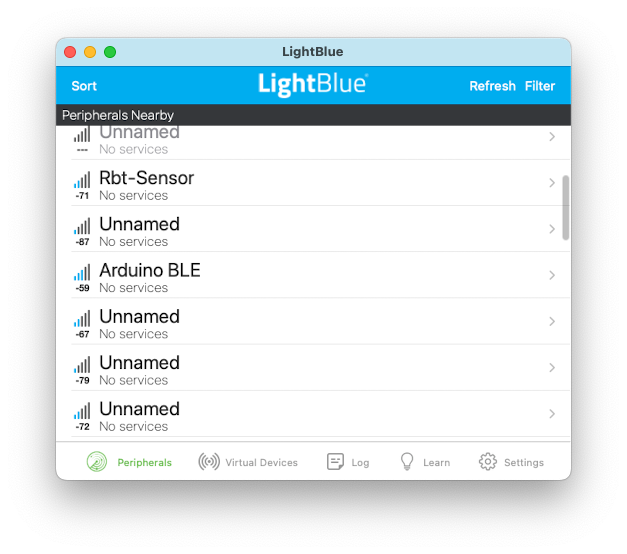
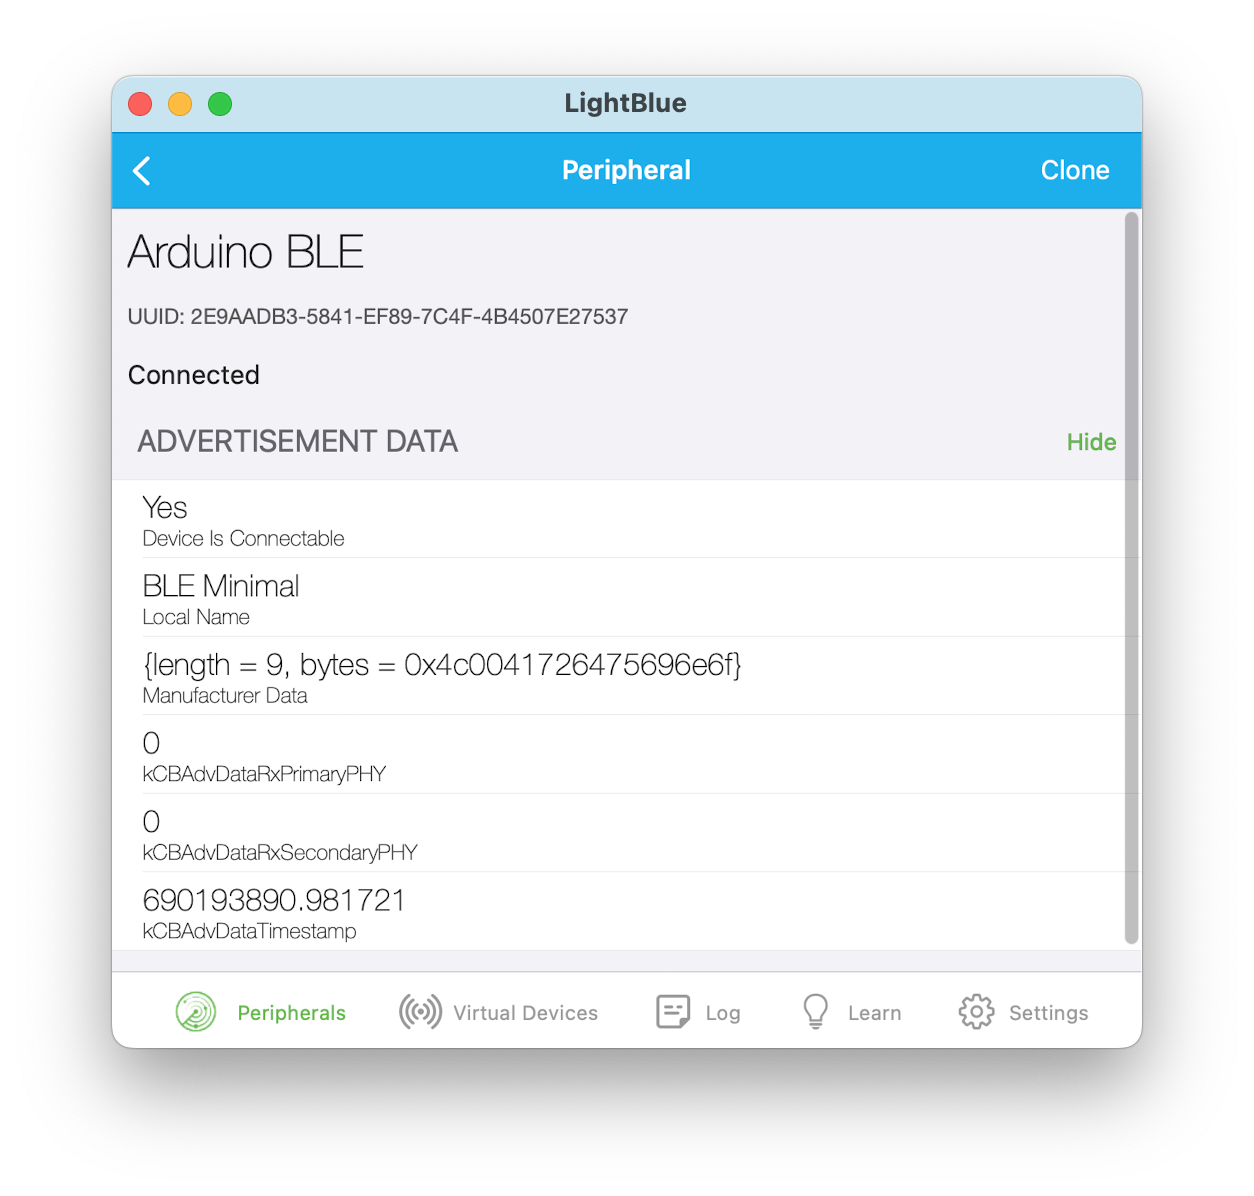
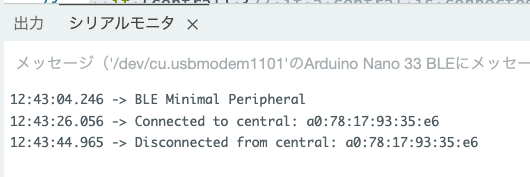

### BLE minimalのスクリプト

このArduino nano 33 BLEデバイスにダウンロードされたスクリプトを以下に示します。

`setup()`関数の中では、アドバタイズ時のデバイスの名称(**"Arduino BLE"**)と、アドバタイズデータ中のローカルな名前(**"BLE Minimal"**)、
を設定しています。設定したこれらのデータは、`BLE.advertiese()`呼び出しにより、ペリフェラルからアドバタイズのデータとして送信されるようになります。

メインループである`loop()`関数では、親となるBLEのセントラルデバイスからの接続要求を待ち、50m秒毎に接続が継続されていることを確認します。接続が切断されると、次のループに移り、再び接続要求を待ちます。

### "BLE minimal"スクリプト

``` cpp
//  Minimal　BLE ペリフェラル：  　Service 無し, キャラックタリステックなし
#include <ArduinoBLE.h>  //ArduinoBLEライブラリを使うための宣言
void setup() {　//初期化
  if (!BLE.begin()) { //BLEの初期化を実行します。
     while (1) {}　//初期化に失敗した場合、スクリプトの実行ははここで永遠に停止します。
  }
  BLE.setDeviceName("Arduino BLE");  //デバイス検索時に表示される名前を設定します。
  BLE.setLocalName("BLE Minimal");   //アドバタイズド　データのローカル　ネーム(local Name)を設定
  BLE.advertise();　// アドバタイズの開始を指示
}
void loop() {　//実行ループ
  BLEDevice central = BLE.central(); // listen for Bluetooth® Low Energy PC to connect:
  if (central) {    // if a central is connected to peripheral:
    while (central.connected()) {    // while the central is still connected to peripheral
      delayMicroseconds(50000);  // 50m秒　= 50000μs 待つ
    }
 }
}
```

## Pythonによる動作確認
Pythonを使って、この"BLE minimal"デバイスの動作を確認してみます。
アドバタイズとして送られてくるデータから、デバイス名が"Auduino BLE"となっているものを探します。
見つかれば、そのペリフェラルのデバイスオブジェクトが返されます。デバイスオブジェクトには、UUIDやアドバタイズ データも`metadata`要素として含まれています。

ペリフェラルデバイスのUUIDがわかっている場合には、アドバタイズ データから、UUID アドレスを検索し、対応するデバイスオブジェクトを入手します。

bleakの関数のいくつかは、コルーチーンなどpythonの非同期入出力の機能(`asyncio`)を使っています。`await`は、指定されたコルーチン(正確にはawaitable オブジェクト）の終了を待ちます。

In [9]:
import logging
from bleak import BleakScanner

# device nameを指定して、検索する。
coro1=BleakScanner.find_device_by_filter(lambda dev, adv: (dev.name == 'Arduino BLE'), timeout=10)
d=await coro1 #コルーチンの終了を待つ
if d: # 結果の出力
  print(f"Found(Name)!\t{d.name=},\n\t{d.address=},\n\t{d.rssi=},\n\t{d.metadata=},\n\t{d.details=}")

# deviceのUUIDを指定して、検索する.
coro2=BleakScanner.find_device_by_address('2E9AADB3-5841-EF89-7C4F-4B4507E27537', timeout=10)
d=await coro2
if d:
  print(f"Found(UUID)!\t{d.name=},\n\t{d.address=},\n\t{d.rssi=},\n\t{d.metadata=},\n\t{d.details=}")

Found(Name)!	d.name='Arduino BLE',
	d.address='2E9AADB3-5841-EF89-7C4F-4B4507E27537',
	d.rssi=-54,
	d.metadata={'uuids': [], 'manufacturer_data': {}},
	d.details=(<CBPeripheral: 0x6000025e41a0, identifier = 2E9AADB3-5841-EF89-7C4F-4B4507E27537, name = Arduino BLE, mtu = 0, state = disconnected>, <CentralManagerDelegate: 0x14c60e7a0>)
Found(UUID)!	d.name='Arduino BLE',
	d.address='2E9AADB3-5841-EF89-7C4F-4B4507E27537',
	d.rssi=-63,
	d.metadata={'uuids': [], 'manufacturer_data': {}},
	d.details=(<CBPeripheral: 0x6000025f8750, identifier = 2E9AADB3-5841-EF89-7C4F-4B4507E27537, name = Arduino BLE, mtu = 0, state = disconnected>, <CentralManagerDelegate: 0x11da30a70>)


## Arduino script: BLE with Device Information Service

BLEではホストとなるCPUとペリフェラルデバイスとの間のデータ交換は、キャラクタリスティックを通じて行います。
EPICSをご存知の方は, BLEのキャラクタリスティックをEPICSのチャンネルのようなものと考えると分かり易いかもしれません。

複数のキャラクタリスティックはペリフェラル中のサービスとして、グループ化されます。
一つのペリフェラルに複数のサービスを定義しておくことができます。Bluetoothの規格では、標準的なサービスとそれに含まれるキャラクタリスティックの組が規格の中で定義されています。　
これらの標準的なサービス／キャラクタリスティックには 16ビットのUUIDが割り当てられています。
この16ビットのUUIDは、”0000XXXX-0000-1000-8000-00805f9b34fb"の128ビットUUIDの省略形と解釈されます。
これらの標準的な16bit UUIDは[Bluetooth® Document: Assigned Numbers](https://www.bluetooth.com/wp-content/uploads/2022/11/assigned_numbers_release.pdf) に記載されています。

次のArduinoスクリプトでは、Arduino nano 33 BLEモジュールに、
[デバイス情報サービス](https://www.bluetooth.com/ja-jp/specifications/specs/device-information-service-1-1/)（"180A")を追加してみます。デバイス情報サービスには、製造者名称("2A29"), モデル番号文字列("2A24"), シリアル番号文字列("2A25")など9種類のキャラクタリステックが用意されていますが、いずれも選択自由なキャラクタリステックとなっています。デバイス情報サービス規格はこれらのキャラクタリステックが実装されている場合には、そのキャラックたりスティックが"Read"プロパティを持っていることを要求しています（Bluetooth Specification: Device Information service, Table 3.1 Device Information Service characteristics)。

ここでは、製造者(manufacture)の名称("2A29")およびモデル番号("2A24")をキャラクタリスティックとして追加してみます。

サービスとキャラクタリスティックの追加には三つのステップが必要です。

 1. サービスおよびキャラクタリスティックのオブジェクトをそれぞれ作成する。
 1. サービスとキャラクタリスティックを関係付る。
 1. サービスをペリフェラルに登録する。

  
オブジェクトはグローバル変数として作成します。また、関係づけ、登録は`setup()`関数の中で実行します。

`setAdvertisedService`はサービスの存在をデバイスがスキャンされる時に通知するアドバタイズデータに登録します。これは、なくても構いませんが、今回は一例として、デバイス情報サービスをアドバタイズデータに登録しています。
アドバタイズデータに登録できるサービスは、***実質*** 一つだけです(アドバタイズデータは、31bytesを超えることはできません。　アクティブSCANでrequest-responceを使ってアドバタイズ データを新たな31bytes以下のデータをホストは入手できるます。

[Assigned Numbers Document]: https://www.bluetooth.com/specifications/assigned-numbers/

以下にこの見本で使用したArduino スクリプトを示します。

``` c++
#include <ArduinoBLE.h>

// Device Information Services
BLEService deviceInformationService("180A");　// standard 16-bit service UUID
BLECharacteristic manufacturerNameChar("2A29",  // standard 16-bit characteristic UUID
                                       BLERead, //　このcharacteristicは読み出し可能
                                       "Arduino®.cc");
BLECharacteristic modelNumberChar("2A24",  // standard 16-bit characteristic UUID
                                  BLERead, //　このcharacteristicは読み出し可能
                                  "Nano 33 BLE LED");

void setup() {
  // begin initialization
  if (!BLE.begin()) { //BLEの初期化を実行します。
     while (1) {}　//初期化に失敗した場合、Arduino 基板はここに永遠に止まります。
  }
  BLE.setDeviceName("Arduino BLE");　// BLE デバイスの検索時に表示される名前を設定します。

  deviceInformationService.addCharacteristic(manufacturerNameChar);  //サービスにキャラクタリスティックを関係づけます
  deviceInformationService.addCharacteristic(modelNumberChar);       // 同上
  BLE.addService(deviceInformationService); // サービスをペリフェラルに登録します。

  BLE.setLocalName("DeviceInfo"); //アドバタイズデータ中のLocalNameを設定します。
  BLE.setAdvertisedService(deviceInformationService);// deviceInformationServiceをアドバタイズメントデータとして登録(オプショナル）

  BLE.advertise();　//アドバタイズを開始します。
}

void loop() {
  // listen for Bluetooth® Low Energy peripherals to connect:
  BLEDevice central = BLE.central();

  // if a central is connected to peripheral:
  if (central) {
    while (central.connected()) {
      delay(100);
    }
  }
}
```

上記のスクリプトを、Arduino IDEを使って、Arduino nano 33 BLEモジュールにダウンロードしてみましょう。
ダウンロードプログラムの書き込みが終了したら、LightBlueアプリケーションで、　デバイスが検索されたデバイスのリストに現れることを確認しましょう。
次に、デバイスに接続して、Device Infomation サービスの内容を確認してみましょう。

Pythonで次のプログラムを（Jupyter Notebookの中で）実行する[注]ことで、ブロードキャストデータが正しく設定されていることを確認できます。
デバイスのUUID('E9AADB3-5841-EF89-7C4F-4B4507E27537')はお手持ちのデバイスに合わせて変更する必要があることに注意してください。

[注] 通常のPythonスクリプトの中では、`asyncio.run(main())` などが必要となります。

In [10]:
import asyncio
import logging
from bleak import BleakScanner

# deviceのUUIDを指定して、検索する.
d=await BleakScanner.find_device_by_address('2E9AADB3-5841-EF89-7C4F-4B4507E27537', timeout=10)
if d:
  print(f"Found(UUID)!\t{d.name=},\n\t{d.address=},\n\t{d.rssi=},\n\t{d.metadata=},\n\t{d.details=}")

Found(UUID)!	d.name='Arduino BLE',
	d.address='2E9AADB3-5841-EF89-7C4F-4B4507E27537',
	d.rssi=-60,
	d.metadata={'uuids': ['0000180a-0000-1000-8000-00805f9b34fb'], 'manufacturer_data': {76: b'Arduino'}},
	d.details=(<CBPeripheral: 0x6000025e8000, identifier = 2E9AADB3-5841-EF89-7C4F-4B4507E27537, name = Arduino BLE, mtu = 0, state = disconnected>, <CentralManagerDelegate: 0x14c6fba80>)


というように、Arduino BLEがBLEデバイスとして検出されました。

### pythonを使って、キャラクタリスティックを読んでみる。

次に、pythonを使って、デバイス情報サービス中のキャラクタリスティックを読み出してみます。

キャラクタリスティックを読み出し、受信データを端末に印刷するには、

  1. デバイスに接続（`BleakClient`)し、
  1. `read_gatt_char`関数でデータを読み出す。読み出すキャラクタリスティックはキャラクタリスティックのUUID(128bit)で指定する。
  　　`read_gatt_char`関数が返す値は、`bytes`型のデータであることに、注意が必要です。
  1. 受信したバイト配列データを印刷可能なユニコード文字列に変換する( `.decode('utf-8')`)
  
  
のステップを踏む必要があります。

In [12]:
import asyncio
from bleak import BleakClient

def UUID_from_uuid(uuid):
  """
  16/32ビットのUUIDを128ビットのUUIDに変換する。
  """
  return f"{uuid:08x}-0000-1000-8000-00805f9b34fb"

MANUFACTURER_Name_UUID=UUID_from_uuid(0x2A29)
MODEL_NBR_UUID=UUID_from_uuid(0x2A24)

async def main(address):
    async with BleakClient(address) as client: # deviceに接続
        manufacturer_name=await client.read_gatt_char(MANUFACTURER_Name_UUID) # キャラクタリスティクを指定して、値を読み出す。
        model_number = await client.read_gatt_char(MODEL_NBR_UUID) 
        print(f"Manufacturer: {manufacturer_name.decode('utf-8')}", #　raw bytesの読み出しデータをunicodeに変換して印刷。 
              f"Model Number: {model_number.decode('utf-8')}"
        )

BLE_UUID='2E9AADB3-5841-EF89-7C4F-4B4507E27537'
# Jupyter Notebook　では次を実行
await main(BLE_UUID)
# その他の環境では次を実行
# asyncio.run(main(BLE_UUID))

Manufacturer: Arduino ®.cc Model Number: Nano 33 BLE


## 書き込み可能プロパティを持つキャラクタリスティックへのデータ書き込み

GATTを用いて、デバイスの持つキャラクタリスティックの値を読むためには、`.read_gatt_char()`を使うことを見ました。
書き込み可能のプロパティを持つキャラクタリスティックにデータを書き込むには、`.write_gatt_char()` を使います。

これを試してみるために、書き込みプロパティを持つキャラクタリスティクをデバイスに実装してみます。
ArduinoBLEのサンプルにあるLEDスクリプトをそのベースに使います。 以下に示すのは動作に必要な部分だけに簡素化したバージョンです。
キャラクタリスティックに1を書き込むとArduino基盤上のLEDが点灯し、0を書き込むと消灯するようにします。

ArduinoBLEのサンプルにあるスクリプトは、モジュールがArduino IDEと接続状態になっていることを仮定しています。ここに示すバージョンは`Serial`を使用していませんので、Arduino nano 33 BLEが電源に接続されていれば、BLEを経由して動作を確認できます。スクリプトをダウンロードしたら、USBケーブルをPCから取り外して、USBケーブルを適当な電源に繋いでみましょう。

[注]  Arduino nano 33シリーズの基板は、CPUのアーキテクチャの違いだけでなく、CPUの動作電圧が3.3V となっているという違いがあります。外部部品を接続する際には、入出力電圧の違いに注意が必要です。

この例にように、16 bitの標準UUIDが割り当てられていない種類のサービス／キャラクタリスティックでは、そのキャラクタリスティックに割り当てる128ビットのUUID/GUID を生成してつかう必要があります。ここでは、AruduinoBLEのサンプルスクリプトで使われているUUID("19B10000-E8F2-537E-4F6C-D104768A1214"および”"19B10001-E8F2-537E-4F6C-D104768A1214")を流用します。

``` C++
/*
  simplified version LED from ArduinoBLE sample scripts.
  This example code is in the public domain.
*/

#include <ArduinoBLE.h>

BLEService ledService("19B10000-E8F2-537E-4F6C-D104768A1214"); // Bluetooth® Low Energy LED Service

// Bluetooth® Low Energy LED Switch Characteristic - custom 128-bit UUID, read and writable by central
BLEByteCharacteristic switchCharacteristic("19B10001-E8F2-537E-4F6C-D104768A1214", BLERead | BLEWrite);

const int ledPin = LED_BUILTIN; // pin to use for the LED

void setup() {
  pinMode(ledPin, OUTPUT); // set LED pin to output mode

  if (!BLE.begin()) {// begin BLE initialization
    while (1);
  }
  BLE.setDeviceName("Arduino BLE");

  ledService.addCharacteristic(switchCharacteristic);  // add the characteristic to the service
  BLE.addService(ledService);// add service
  switchCharacteristic.writeValue(0);// set the initial value for the characeristic:

  BLE.setLocalName("LED"); // set advertised local name and service UUID:
  BLE.setAdvertisedService(ledService);
  BLE.advertise(); // start advertising
}

void loop() {
  BLEDevice central = BLE.central();// listen for Bluetooth® Low Energy peripherals to connect:

  if (central) {// if a central is connected to peripheral:
    while (central.connected()) { // while the central is still connected to peripheral:
      if (switchCharacteristic.written()) {// if the remote device wrote to the characteristic,
        if (switchCharacteristic.value()) {   // any value other than 0
          digitalWrite(ledPin, HIGH);         // will turn the LED on
        } else {                              // a 0 value
          digitalWrite(ledPin, LOW);          // will turn the LED off
        }
      }
    }
  }
}
```

### 動作確認: LightBlueを使って。

LightBlueを開き、探索画面で、"Aruduino BLE"が表示されたらそのデバイスを選択します。

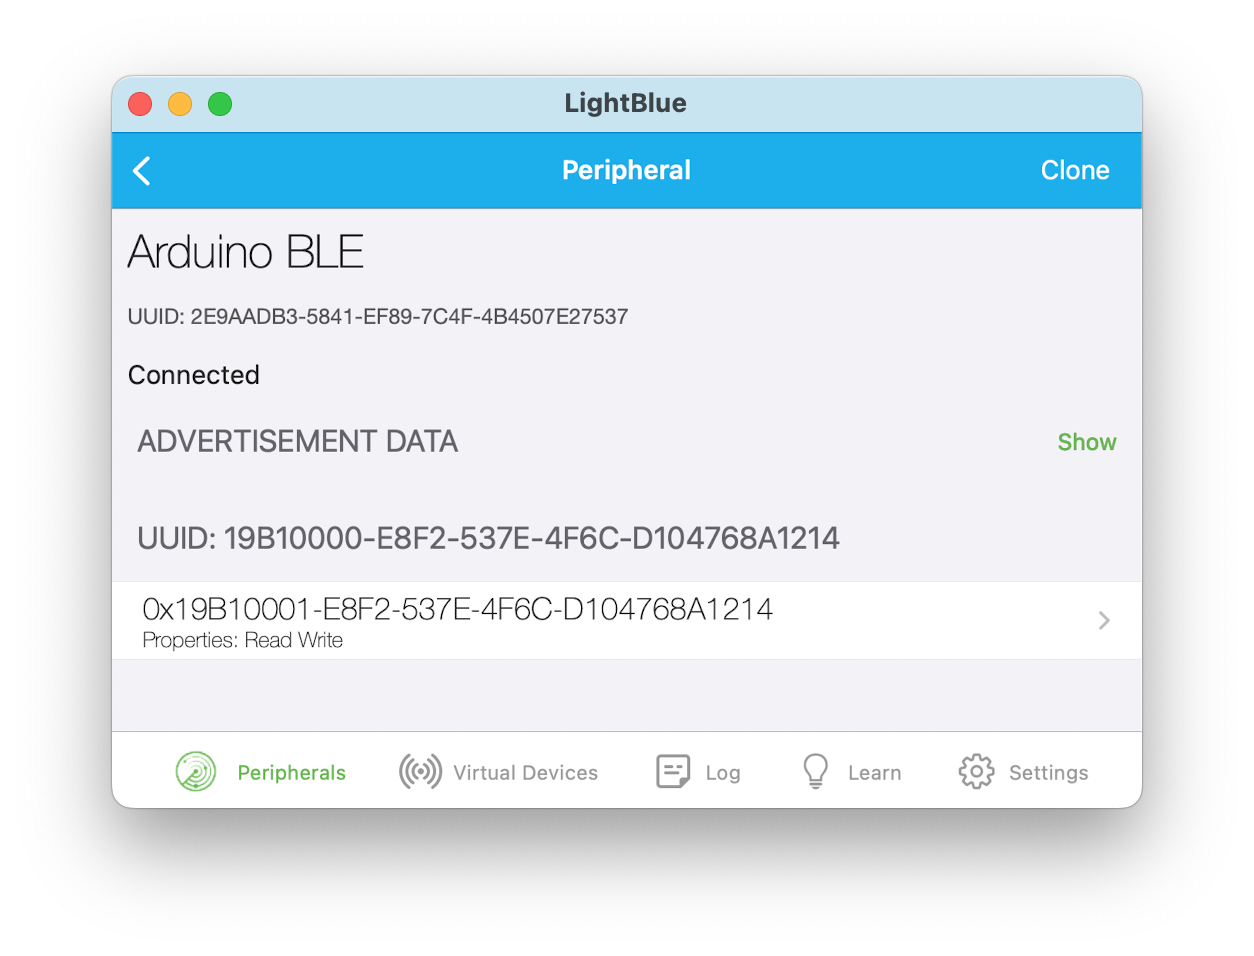

uuidが"19B10001-E8F2-537E-4F6C-D104768A1214"のキャラクタリスティックを選択して、開きます。

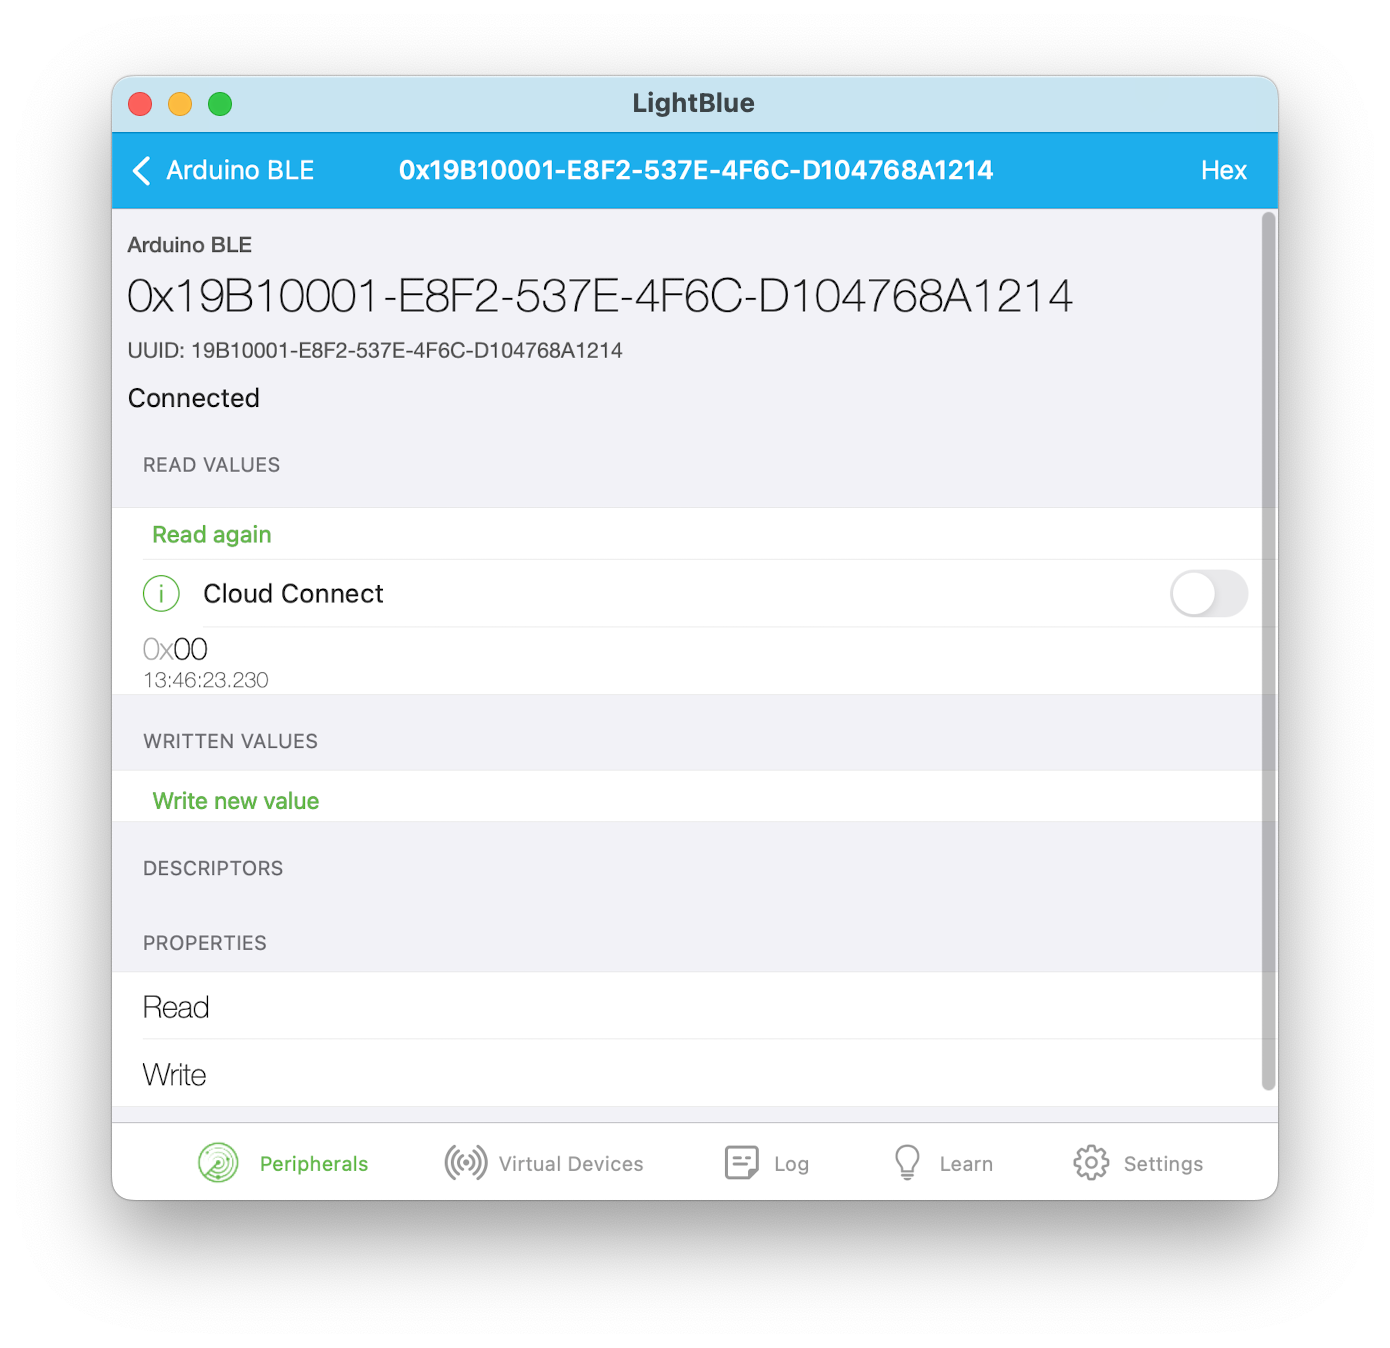
Read/Writenのプロパティが割り当てられているこ
とを確認した上で、”write new value"ボタンを使って、値を設定してみましょう。
0以外の値を書き込むと、Arduino  のオンボードLEDが点灯し、0を書き込むと、消灯することを確認しましょう。

動作の状態を次の動画でご覧ください。

In [2]:
#特性へのデータ書き込み
from IPython.display import Video
Video('./_movies/画面収録 2023-01-24 18.05.45.m4v',height=250)

### 動作確認: python/bleakを使って。

pythonを使って、Arduino基板のオンボードLEDをBLEのサービスを使って、点滅させるスクリプトを作ってみましょう。
繰り返し回数(`rep`)および点滅の間隔(`wait`)をパラメータとすることにしましょう。

プログラムの一例をご覧ください。：これを(Jupyter Notebookの中で）実行して、基板のLEDが点滅することを確認しましょう。
`main` 関数のパラメータを変えて, 動作が変わるのを確認しましょう。


In [2]:
import asyncio
from bleak import BleakClient
import datetime

LED_SWITCH_CHAR_UUID="19b10001-e8f2-537e-4f6c-d104768a1214"

async def main(address, wait=5,rep=1):
    async with BleakClient(address) as client:
        await client.write_gatt_char(LED_SWITCH_CHAR_UUID, b"\x00", response=True) 
        OnOff=0
        print("start blink")
        for i in range(2*rep): #On-Offを繰り返す
          await client.write_gatt_char(LED_SWITCH_CHAR_UUID, f"{OnOff:c}".encode('ascii'), response=True)
          await asyncio.sleep(wait)
          OnOff=1-OnOff
        else: # 最後にLEDを消灯
          await client.write_gatt_char(LED_SWITCH_CHAR_UUID, b"\x00", response=True) 
        print("done")

BLE_UUID='2E9AADB3-5841-EF89-7C4F-4B4507E27537'
# Jupyter Notebook　では次を実行
await main(BLE_UUID, 0.5, 5)
# その他の環境では次を実行
# asyncio.run(main(BLE_UUID, 0.3, 5))

start blink
done


In [3]:
#Pythonを使ってBLE装置へデータを書き込む
from IPython.display import Video
Video('./_movies/画面収録 2023-01-25 7.39.42.mov',width=480)

### python/bleakでの`.write_gatt_char`の使い方

python/bleakでの`.write_gatt_char`の使い方では次の２点に注意する必要があります。
まず、`.write_gatt_char`のプロトタイプは次のようになっています。

``` python
    async def write_gatt_char(
        self,
        char_specifier: Union[BleakGATTCharacteristic, int, str, uuid.UUID],
        data: Union[bytes, bytearray, memoryview],
        response: bool = False,
    ) -> None:
```
となっています。

まず送信するデータは生なバイトデータ`bytes, bytearray, memoryview` を送信する必要があります。

次に`response`フラグはArduino側の`switchCharacteristic.written()`を予期したように動作させるために、`True`に設定する必要があります。 このフラグは、GATTの `WriteWithResponse` を使うか `WriteWithoutResponse`を使うかを選択しています。 (ArduinoBLEをこれまで使った範囲では、`response=False`の場合は、設定したevent Handlerや`.written()`は予期した動作をしません(writeを実行してもデバイス側ではそれに対応するエベントが発生しません）。

## Nofity プロパティ

BLEのキャラクタリスティックは、Read, Write の他に Notify プロパティを持つことができます。

Notifyプロパティを持つキャラクタリスティックは、その値が更新された時に、ペリフェラルデバイスから、マスター(PC、スマホなどのホスト）に通知を送ることができます。EPICSをご存知の方はチャンネルのモニタと同じような機能と考えていただいていいでしょう。

Notify機能のサンプルとして、温度センサをArduino nano 33 BLEに接続し、検出した温度が前回の数値と異なっているときに、接続されたマスタに通知を送るBLE を構成してみます。

この例では、[テキサス　インスツルメント社の温度センサ LM60](https://www.ti.com/product/ja-jp/LM60)をArduino nano 33 BLEのアナログ入力端子7番(A7, Arduino nanoのピン配置図を参照)に接続します。　この素子の電源ピンはAruduino 基板の3.3Vピン、グランドピンは基板のグランドピンに接続しています。Arduino nano 33 BLE基板はその名が示すように3.3Vの電圧での入出力動作を行います。5VピンにはUSBの電源から5V電圧が出ていますが、これを直接Arduinoの入出力ピンに接続してはいけません。　[Arudino Nano 33のピン配置]に注意して素子を基盤と接続します。

``` C++
/*
  LM60

  This example code is in the public domain.

  this version was modified/extended by N.YAMAMOTO, KEK (2022 Nov.)
*/

#include <ArduinoBLE.h>

// グローバル変数　定義

// Temperature Service　関係のグローバル変数
// 0x181A Environmental Sensing
BLEService temperatureService("181A");  // グローバル変数TemperatureServiceの宣言／定義。"181A":Environmental Sensing
// Bluetooth® Low Energy 環境温度
BLEFloatCharacteristic temperatureChar("2A1C",             // "2A1C":Temperature Measurement
                                      BLERead | BLENotify); 

float oldTemperature = 25.0;     // OLD Temperature data by LM60 
long notify_previousMillis = 0;  // 温度を最後に測定した時刻, in ms
const long NOTIFY_INTERVAL = 200; //データを更新する時間間隔(ミリ秒)
// a function to update temperature data.

void updateTemperature() {
  /* Read the LM60 voltage level on the A7 analog input pin.
  */
  analogReadResolution(16);//Arduino nano 33 BLE の　ADC　は　12bits.
  
  int temperatureRaw = analogRead(A7); 
  float temperature = map(temperatureRaw, 0, 65535, 0, 3300);// converte to mv
  //VO =(6.25mV/°C×T°C)+424mV
  temperature=(temperature-424.0)/6.25;
  if (Serial) {
      Serial.print("temperature(Celsius) °C:");  // print it
      Serial.println(temperature);
   }
  if (temperature != oldTemperature) {        // if the environmental temperature has changed
    temperatureChar.writeValue(temperature);  // and update the temperature characteristic
    oldTemperature = temperature;             // save the level for next comparison
  }
}

void setup() {
  Serial.begin(115200);
  delay(5000);  // Serial portがレディになるのを待つ。2000msecでは不十分な場合があるようです。
  // Arduinoを単独使用の場合には、Serialを無限に待つことはできないので, Serailオブジェクトが生成されたかどうかをチェックします。
  if (Serial) {
    Serial.print("Serial port is available.\n");//
  };

  // begin initialization
  if (!BLE.begin()) {
    if (Serial) Serial.println("starting Bluetooth® Low Energy module failed!");
    while (1) {} //BLEの初期化に失敗したので、このスケッチはここで永遠に停止します。
  }
  BLE.setDeviceName("Arduino BLE");  

  temperatureService.addCharacteristic(temperatureChar);  // add the battery level characteristic
  BLE.addService(temperatureService);                 // Add the battery service
  temperatureChar.writeValue(oldTemperature);        // set initial value for this characteristic

  BLE.setLocalName("BLE LM60 Sample");

  BLE.setAdvertisedService(temperatureService); // service_uuids

  // start advertising
  BLE.advertise();

  if (Serial) Serial.println(F("start Temperature monitoring."));
}

void loop() {
  // listen for Bluetooth® Low Energy peripherals to connect:
  BLEDevice central = BLE.central();

  // if a central is connected to peripheral:
  if (central) {
    if (Serial) Serial.print("Connected to central: ");
    // print the central's MAC address:
    if (Serial) Serial.println(central.address());
    // while the central is still connected to peripheral:
    while (central.connected()) {
      long currentMillis = millis();
      // if NOTIFY_INTERVAL have passed, check the Temperature:
      if (currentMillis - notify_previousMillis >= NOTIFY_INTERVAL) {
        updateTemperature();
        notify_previousMillis = currentMillis;
      }
    }

    // when the central disconnects, print it out:
    if (Serial) Serial.print(F("Disconnected from central: "));
    if (Serial) Serial.println(central.address());
  }
}
```

### Arduino nanoのピン配置　[注]_


[注] Arduino nano 33シリーズの基板は、CPUのアーキテクチャの違いだけでなく、CPUの動作電圧が3.3V となっている
という違いがあります。外部部品を接続する際には、入出力電圧の違いに注意が必要です。

<caption> Arduino nano 基板の入出力ピン割り当ては次の図のようになっています。</caption>

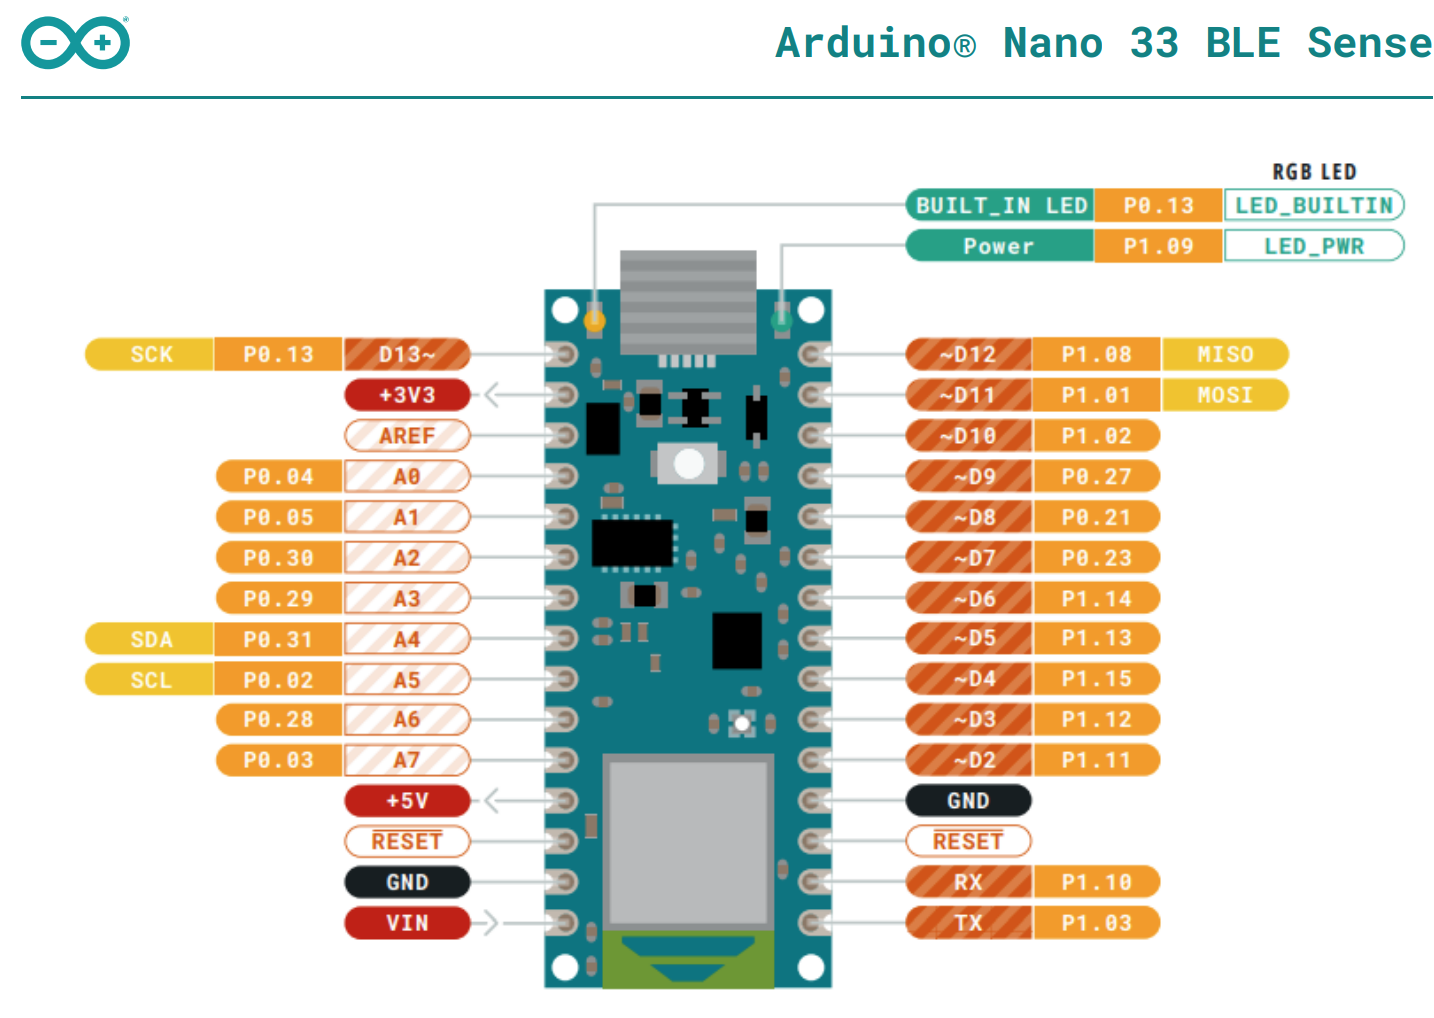


<caption> LightBlueアプリケーションを使って、Notifyキャラクタリスティクを観察してみます。 "start listening" をクリックすることで、デバイスから送られた新しい測定値の通知を受信します。</caption>

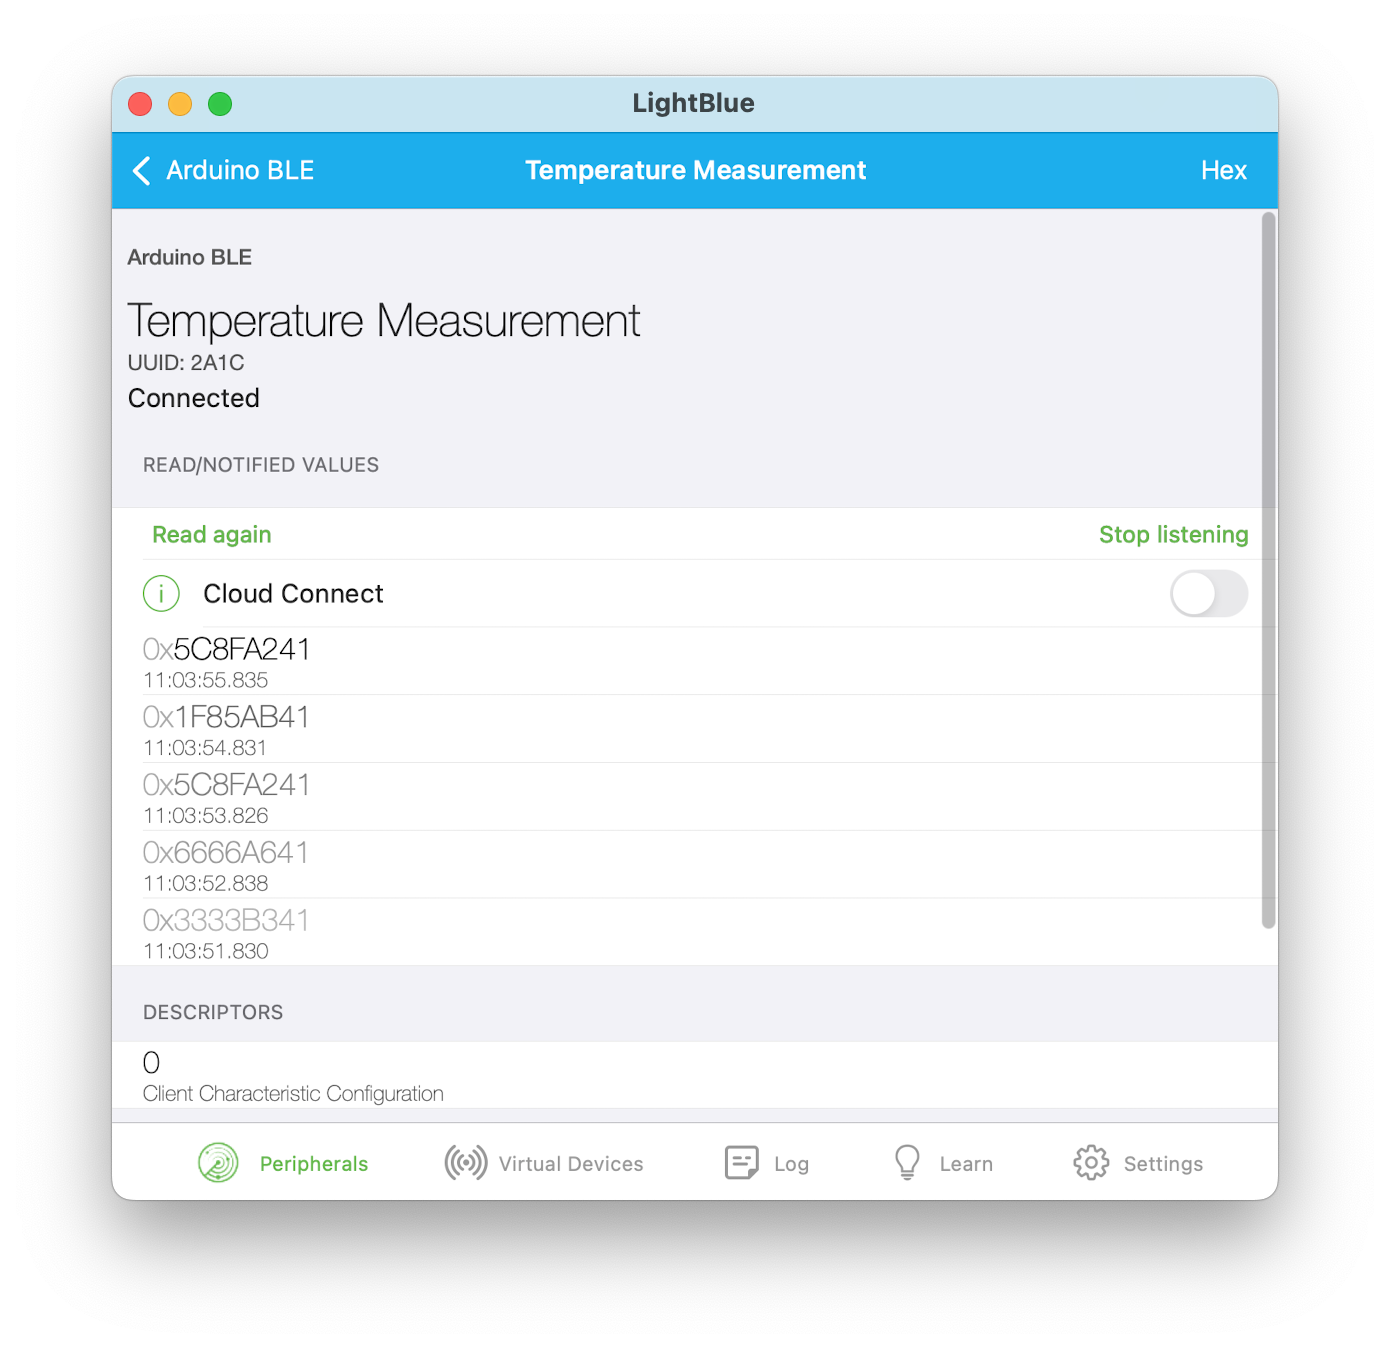


画面右上のデータフォーマット('HEX'や'FLT')をクリックすることで、表示の形式を変更することができます。

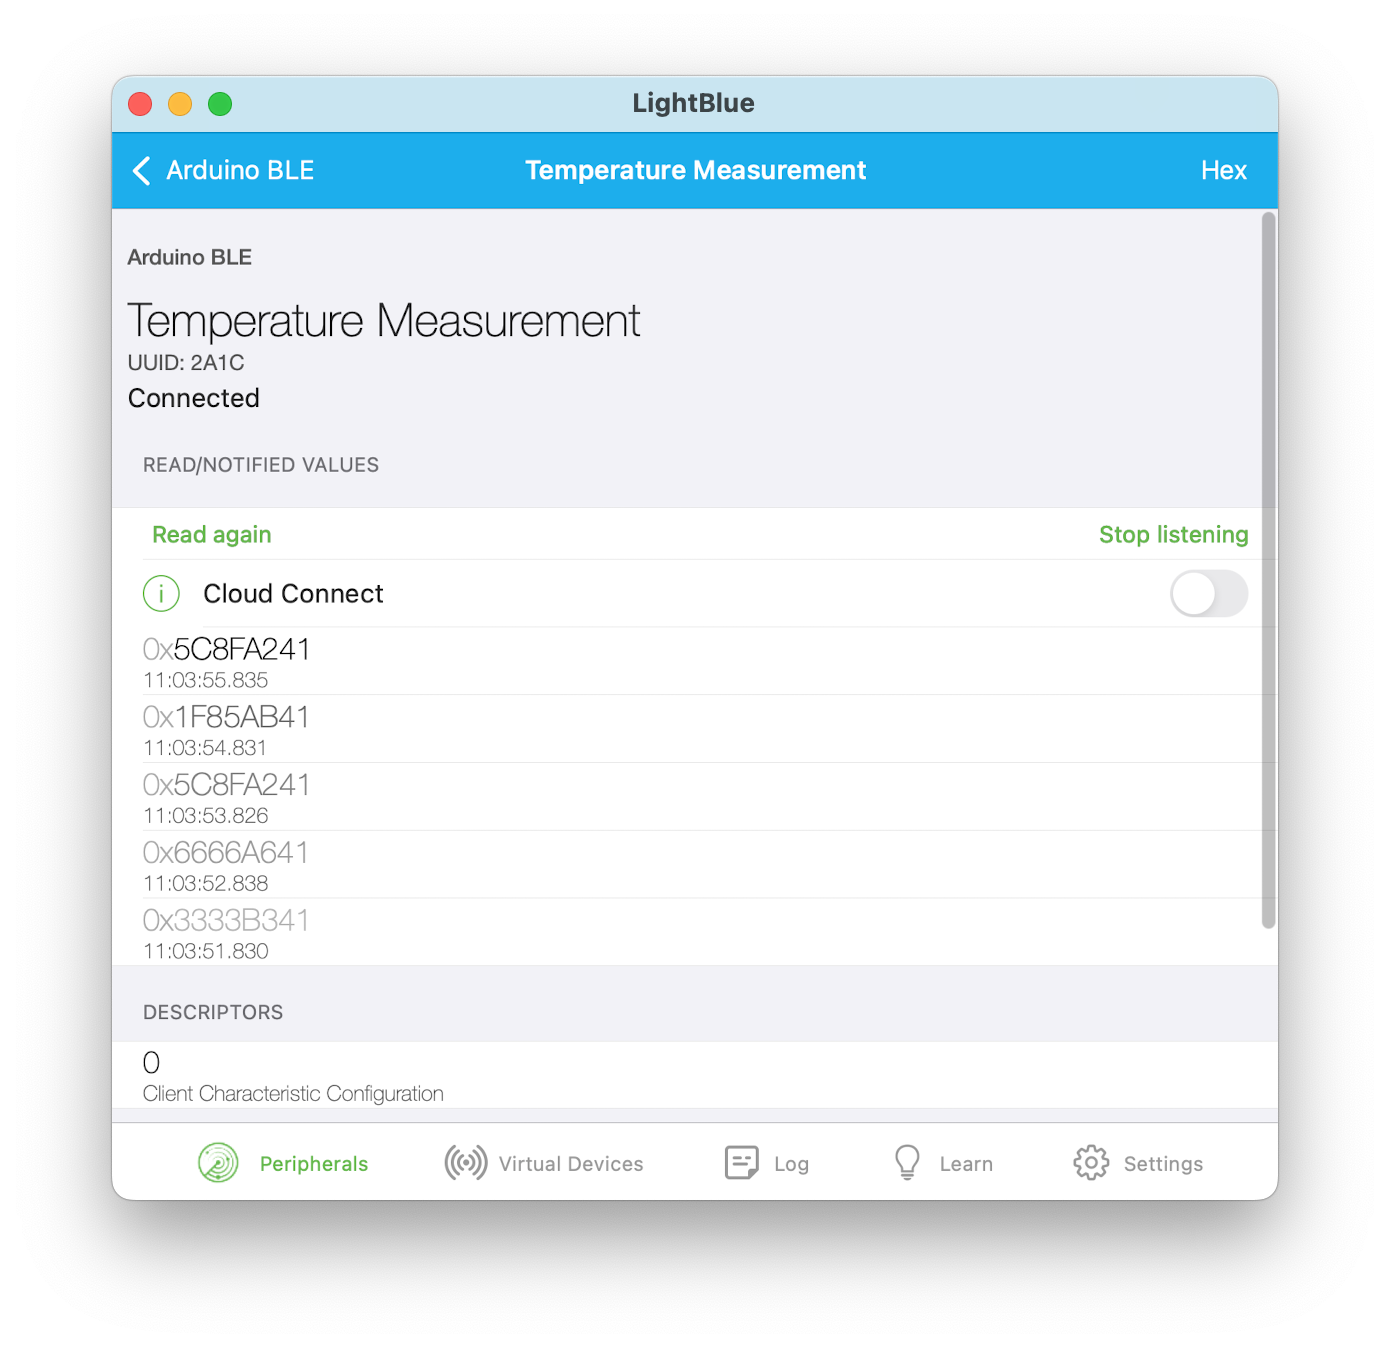

<caption> Arduino IDEを接続した状態では、測定毎の温度がシリアルモニタに表示されます。</caption>

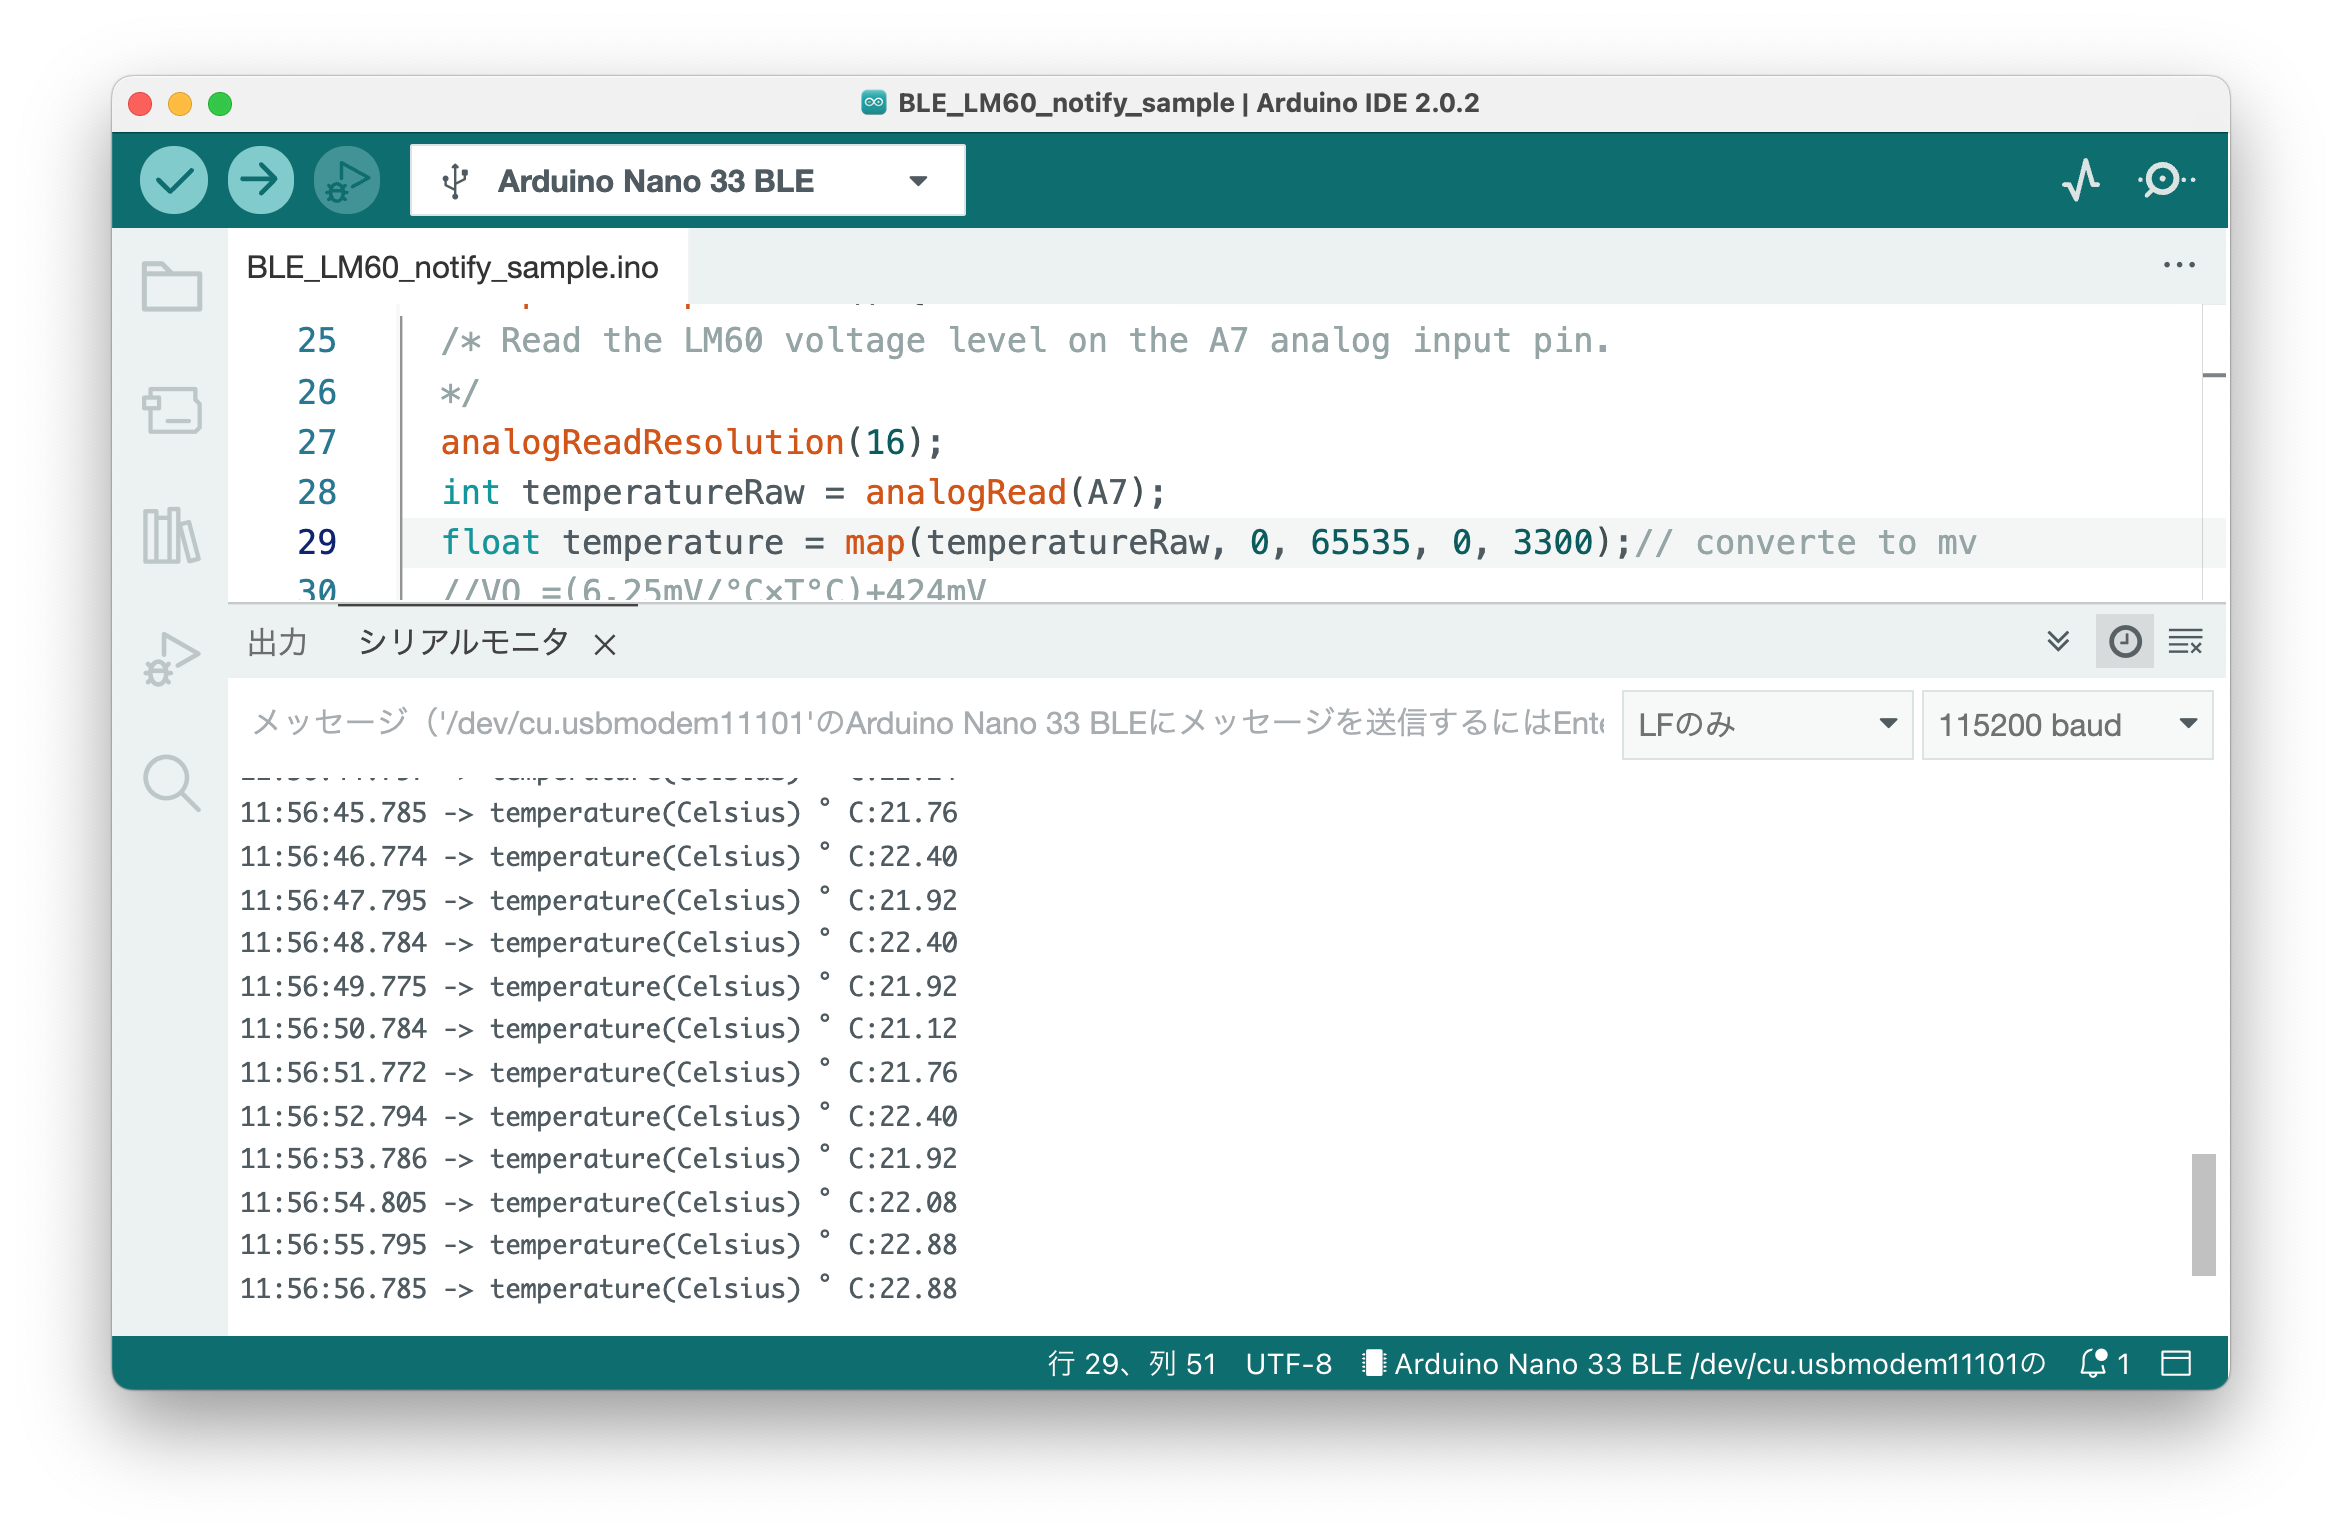


<caption> Arduino IDEのシリアルプロッタを使うと、このデータを時系列グラフとして表示できます。</caption>

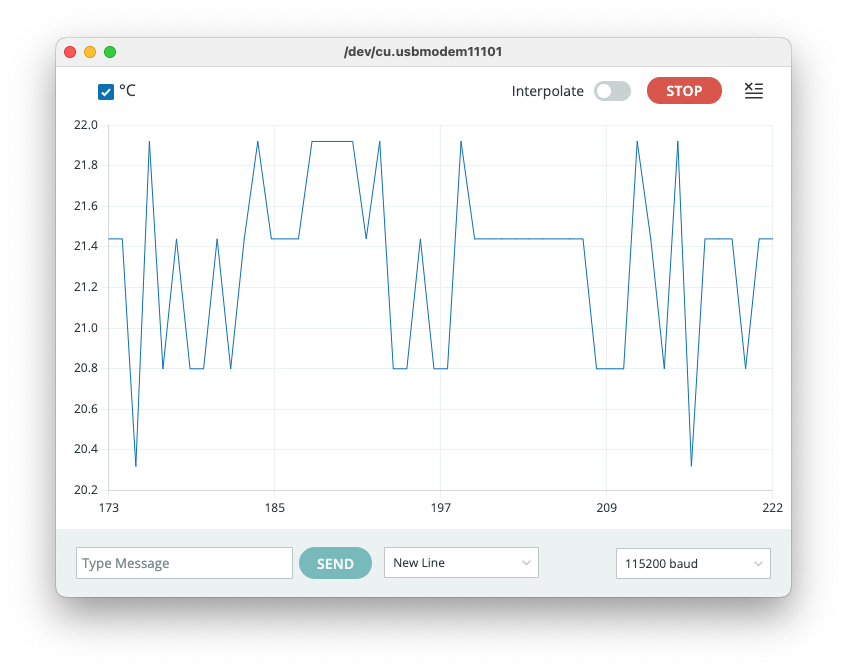

In [5]:
#データ表示形式の変更
from IPython.display import Video
Video('./_movies/画面収録 2023-01-24 18.15.56.m4v',height=360)

In [3]:
import asyncio
import datetime,time,struct
from bleak import BleakClient

BLE_device="2E9AADB3-5841-EF89-7C4F-4B4507E27537"

BLE_Temperature_UUID = "00002a1c-0000-1000-8000-00805f9b34fb"

def notification_handler(sender, data):
    print("env temp:  {1:f} deg Celsius at {2} raw data: {0}".format(
      data,
      struct.unpack("f",data)[0], 
      datetime.datetime.now().isoformat()))

#asyncio.run(main(address))
async def main(address, delay=10,rep=10,):
  async with BleakClient(address) as client:
    await client.start_notify(BLE_Temperature_UUID, notification_handler)
    chache_flag=False 
    await asyncio.sleep(delay)
    res=await client.stop_notify(BLE_Temperature_UUID)
    
await main(BLE_device,5)

env temp:  12.026298 deg Celsius at 2023-01-02T16:46:30.869653 raw data: bytearray(b'\xb7k@A')
env temp:  11.959667 deg Celsius at 2023-01-02T16:46:31.169826 raw data: bytearray(b'\xccZ?A')
env temp:  11.895238 deg Celsius at 2023-01-02T16:46:32.069932 raw data: bytearray(b'\xe5R>A')
env temp:  11.844688 deg Celsius at 2023-01-02T16:46:33.285451 raw data: bytearray(b'\xd8\x83=A')
env temp:  11.891418 deg Celsius at 2023-01-02T16:46:34.185089 raw data: bytearray(b'?C>A')
env temp:  11.806275 deg Celsius at 2023-01-02T16:46:34.500376 raw data: bytearray(b'\x81\xe6<A')
env temp:  11.761647 deg Celsius at 2023-01-02T16:46:34.785037 raw data: bytearray(b'\xb5/<A')


## まとめ

Arduino nano 33 BLEをBLE周辺機器（ペリフェラル）として使う方法およびそのBLE機器をPythonプログラムから制御する方法について説明しました。Read/Write/Notifyのプロパティをもつキャラクタリステック(特性)について、使用例をご覧いただきました。
Arduino IDE/ Light BLE/ Python& bleak moduleなどを組み合わせてつかうことで、Ardiono Nano 33 BLEをBLE デバイスとして応用することが可能であることをご理解いただけたかと思います。



## 付録1 python bleak モジュールのインストール方法と利用例

まずは現在 python3 でのBLEサポートの事実上の標準となっているbleakをインストールします。
```
%python3 -m pip install -U bleak
```
pipをJupyter ノートブックカーネル中で使うことも可能です。

In [19]:
%automagic off


Automagic is OFF, % prefix IS needed for line magics.


In [9]:
# Jupyter Notebook中でbleak モジュールをインストールするには、次の行をアンコメントしてセルを実行します。
#!pip install -U bleak
# 標準に含まれないサーヴィスやキャラクタリスティックのUUIDと表示名との対応を登録する。
import bleak.uuids
bleak.uuids.register_uuids({
  "19b10000-e8f2-537e-4f6c-d104768a1214":"LED service",
  "19b10001-e8f2-537e-4f6c-d104768a1214":"LED switch"
})